<div class="alert alert-block alert-success">

# **1.** **Setup**

<div>

In [1]:
from utils import *

In [2]:
# Set random seeds for reproducibility
tf.random.set_seed(221)
random.seed(221)
np.random.seed(221)
tf.random.set_seed(221)

## **1.1** Datasets

In [3]:
# Load the train/val split data
with open('train_val_split.pkl', 'rb') as f:
    data = pickle.load(f)

# Store the data in variables
x_train = data['x_train']
x_val = data['x_val']
y_train = data['y_train']
y_val = data['y_val']

In [4]:
# For EXTRA

# Load the train/val split data without preprocessing
with open('train_val_split_no_preproc.pkl', 'rb') as f:
    data_no_preproc = pickle.load(f)

# Convert DataFrames to list
train_texts = data_no_preproc['x_train'].tolist()
val_texts = data_no_preproc['x_val'].tolist()

# Convert Series to list
train_labels = data_no_preproc['y_train'].tolist()
val_labels = data_no_preproc['y_val'].tolist()

## **1.2** Parameters

In [5]:
# ------- Parameters ------- 
# Glove
emb_size = 200

# BoW and TF-IDF
max_df = 0.7 # we are removing terms that appear in >70% of tweets
min_df = 1 

# Word2Vec
window = 2         # context window size
min_count = 1      # minimum word frequency to include

# KNN
n_neighbors = 10
metric = 'cosine'
weights = 'distance'

# Naive Bayes
alpha = 1

# Random Forest
n_estimators = 200
criterion = 'gini'
max_depth = 20 # to control overfitting
min_samples_split = 10 # to avoid split on very small groups
min_samples_leaf = 3 # to avoid very specific rules
max_features = 'sqrt'
class_weight = 'balanced'

# Logistic Regression
penalty = 'elasticnet'
solver = 'saga'
l1_ratio = 0.5
C = 0.15
class_weight = 'balanced'
max_iter=300
multi_class='multinomial'

# XGBoost
objective='multi:softmax'
num_class=3
eval_metric='mlogloss'
use_label_encoder=False
learning_rate = 0.05 # for better convergence
max_depth_xgboost = 6
n_estimators_xgboost = 300
subsample = 0.8 # 80% of rows per tree to reduce overfitting
colsample_bytree = 1
scale_pos_weight = 1

# LSTM
batch_size=16
epochs=10
sg=1
learning_rate_lstm=0.001
optimizer=Adam(learning_rate=learning_rate_lstm)
loss='categorical_crossentropy'
metrics=['categorical_accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc', multi_label=True)]
units=64
dropout=0.3

## **1.3** General

In [6]:
corpus = x_train['text']

#get list with lenghts of sentences
train_len = []
for i in corpus:
    train_len.append(len(i))

vector_size = max(train_len)

metrics_df = []

In [7]:
tokenized_train = [word_tokenize(tweet.lower()) for tweet in x_train['text']]
max_seq_len = max(len(tokens) for tokens in tokenized_train)

## **1.4** Models

### Glove

In [8]:
model_name = 'glove-twitter'
glove_model = gensim.downloader.load(f'{model_name}-{emb_size}')

### Text Embeddings 3 Small

In [9]:
# EXTRA

# Load variables from .env into environment
load_dotenv()

# Print environment variable
print("AZURE_OPENAI_ENDPOINT:", os.getenv("AZURE_OPENAI_ENDPOINT"))

# Initialize Azure OpenAI client
client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_KEY"),
    api_version="2024-02-01",
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT")
)

# Define embedding model
model = "text-embedding-3-small"

AZURE_OPENAI_ENDPOINT: https://novaimsplayground.openai.azure.com/


In [10]:
# Define embedding model text embedding
model_te3s = "text-embedding-3-small"

### Roberta

In [11]:
# Load the pre-trained model and tokenizer for roberta
model_name = "cardiffnlp/twitter-roberta-base"
tokenizer_roberta = AutoTokenizer.from_pretrained(model_name)
model_roberta = AutoModel.from_pretrained(model_name)

### LSTM

In [12]:
input_ = Input(shape=(max_seq_len, vector_size))

x = Masking(mask_value=0.0)(input_)
x = Bidirectional(LSTM(units=units, return_sequences=False, dropout=dropout, recurrent_dropout=dropout))(x)
x = Dropout(dropout)(x)
output = Dense(num_class, activation='softmax')(x)

<div class="alert alert-block alert-success">

# **2.** **KNN**

<div>

## **2.1** Bag of Words

### **2.1.1** Unigrams

In [17]:
modelknn = KNeighborsClassifier(n_neighbors = n_neighbors, metric = metric, weights = 'distance')

# each term is marked as present or not per document - good for short text
X_bow_unigrams, y_train_pred_bow_unigrams, y_val_pred_bow_unigrams, bow_unigrams = embedding_bow(x_train=x_train, y_train=y_train, x_val=x_val, max_df=max_df, min_df=min_df, model=modelknn)

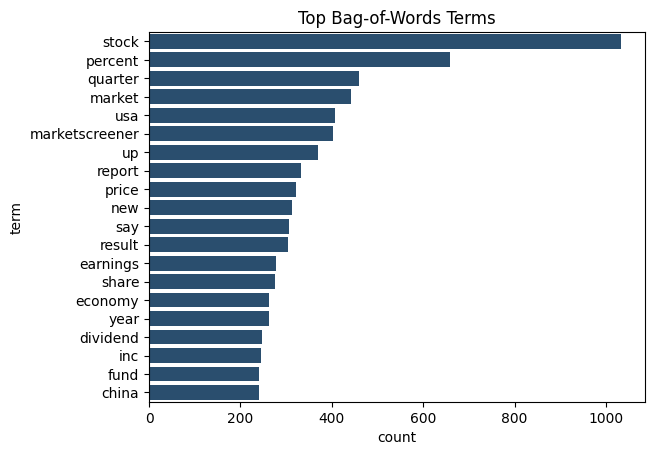

In [18]:
clean_bow_sum = np.array(X_bow_unigrams.sum(axis=0)).flatten()
clean_terms = bow_unigrams.get_feature_names_out()
clean_top = pd.DataFrame({'term': clean_terms, 'count': clean_bow_sum}).sort_values(by='count', ascending=False).head(20)

sns.barplot(data=clean_top, x='count', y='term', color='#1f4e79')
plt.title("Top Bag-of-Words Terms")
plt.show()

In [19]:
title = "KNN BoW Unigrams"

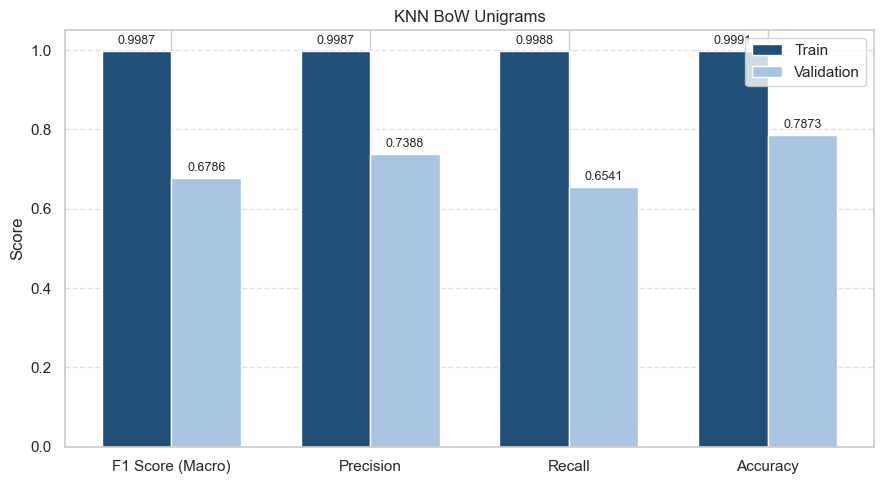

In [20]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_bow_unigrams, y_val, y_val_pred_bow_unigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_bow_unigrams, y_val, y_val_pred_bow_unigrams, title=title)

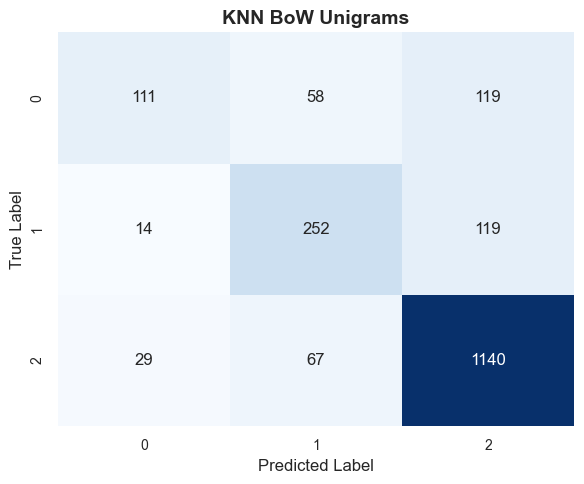

In [21]:
plot_confusion_matrix(y_val, y_val_pred_bow_unigrams, title=title, labels=[0, 1, 2], cmap="Blues")

### **2.1.2** Unigrams + Bigrams

In [22]:
modelknn = KNeighborsClassifier(n_neighbors = n_neighbors, metric = metric, weights = 'distance')

X_bow_bigrams, y_train_pred_bow_bigrams, y_val_pred_bow_bigrams, bow_bigrams = embedding_bow(x_train=x_train, y_train=y_train, x_val=x_val, model=modelknn,max_df=max_df, min_df=min_df, ngram_range=(1,2), oversampling_function=oversample)

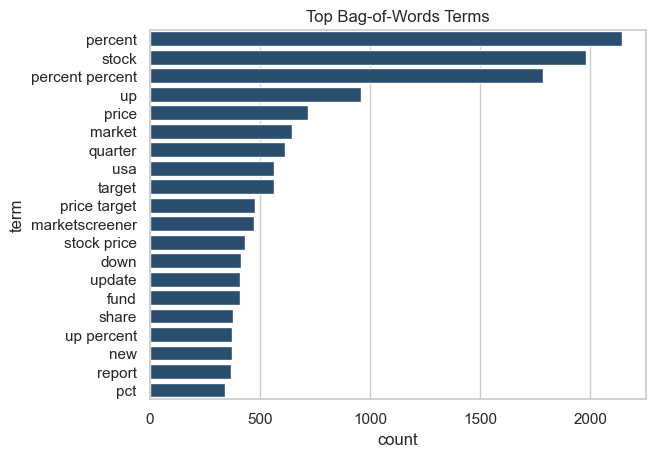

In [23]:
clean_bow_sum = np.array(X_bow_bigrams.sum(axis=0)).flatten()
clean_terms = bow_bigrams.get_feature_names_out()
clean_top = pd.DataFrame({'term': clean_terms, 'count': clean_bow_sum}).sort_values(by='count', ascending=False).head(20)

sns.barplot(data=clean_top, x='count', y='term', color='#1f4e79')
plt.title("Top Bag-of-Words Terms")
plt.show()

In [24]:
title = "KNN BoW Bigrams"

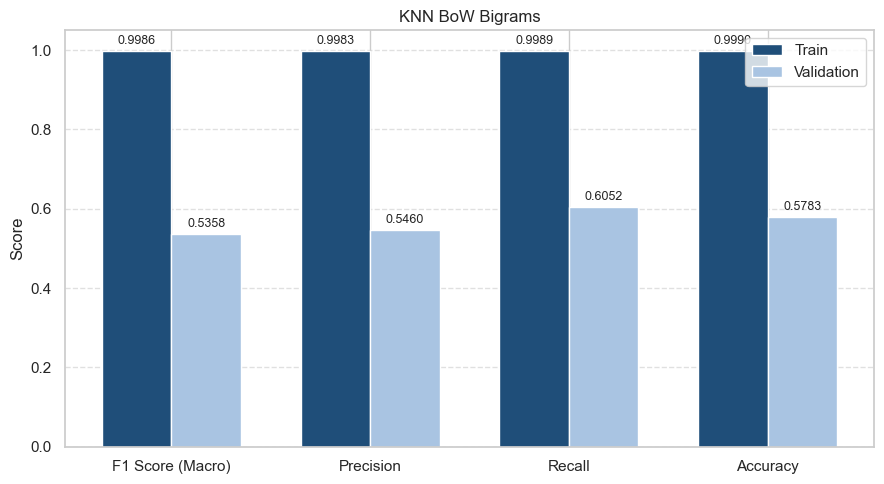

In [25]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_bow_bigrams, y_val, y_val_pred_bow_bigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_bow_bigrams, y_val, y_val_pred_bow_bigrams, title=title)

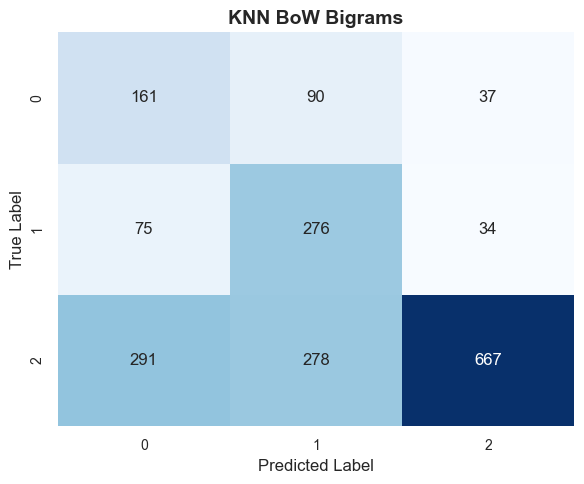

In [26]:
plot_confusion_matrix(y_val, y_val_pred_bow_bigrams, title=title, labels=[0, 1, 2], cmap="Blues")

## **2.2** TF-IDF

### **2.2.1** Unigrams

In [27]:
modelknn = KNeighborsClassifier(n_neighbors = n_neighbors, metric = metric, weights = weights)

X_tfidf_unigrams, y_train_pred_tfidf_unigrams, y_val_pred_tfidf_unigrams, tfidf_unigrams = embedding_tfidf(x_train=x_train, y_train=y_train, x_val=x_val, min_df=min_df, max_df=max_df, model=modelknn)

In [28]:
tfidf_unigrams.get_feature_names_out()

array(['aa', 'aal', 'aaoi', ..., 'zyen', 'zynex', 'zynga'], dtype=object)

In [29]:
tfidf_unigrams.vocabulary_

{'nasdaq': 6770,
 'price': 7929,
 'percent': 7540,
 'senior': 9088,
 'note': 7003,
 'future': 4195,
 'up': 11999,
 'november': 7020,
 'nonfarm': 6959,
 'private': 7954,
 'payroll': 7492,
 'consensus': 2242,
 'ticker_econx': 10802,
 'twitter': 11844,
 'user': 12045,
 'explain': 3714,
 'kohl': 5671,
 'stock': 9718,
 'got': 4428,
 'obliterated': 7091,
 'reporting': 8491,
 'earnings': 3229,
 'agilysys': 260,
 'restaurant': 8553,
 'find': 3928,
 'sustainable': 9934,
 'method': 6438,
 'limiting': 5936,
 'food': 4041,
 'waste': 12290,
 'holiday': 4812,
 'make': 6163,
 'retirement': 8581,
 'top': 11634,
 'ranked': 8225,
 'mutual': 6727,
 'fund': 4182,
 'february': 3854,
 'could': 2390,
 'applied': 590,
 'dna': 3043,
 'science': 8979,
 'inc': 5086,
 'apdn': 569,
 'see': 9048,
 'reversal': 8605,
 'breaking': 1376,
 'week': 12339,
 'low': 6065,
 'lamp': 5737,
 'news': 6873,
 'usmca': 12048,
 'affect': 225,
 'usa': 12037,
 'steelmaker': 9681,
 'auto': 818,
 'manufacturer': 6210,
 'manchester': 619

In [30]:
# get the IDF score for each term
idf_dict = dict(zip(tfidf_unigrams.get_feature_names_out(), tfidf_unigrams.idf_))

# Get the first 10 items
idf_dict_10 = dict(list(idf_dict.items())[4100:4110])

print(idf_dict_10)

{'foxbusiness': 8.553679816169742, 'foxconn': 8.553679816169742, 'foxnews': 9.246826996729688, 'fpga': 9.246826996729688, 'fpp': 9.246826996729688, 'fpt': 9.246826996729688, 'fq': 8.841361888621524, 'fracking': 9.246826996729688, 'fractional': 9.246826996729688, 'fractionally': 8.841361888621524}


In [31]:
title = "KNN TF-IDF Unigrams"

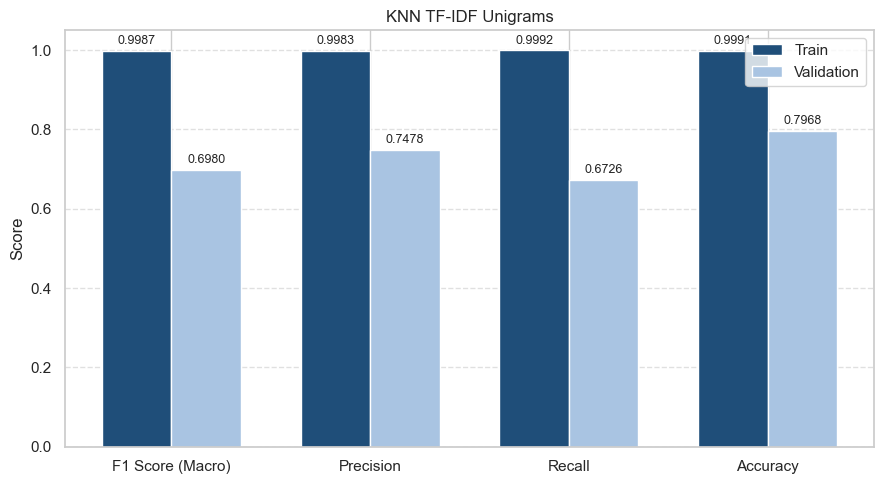

In [32]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_tfidf_unigrams, y_val, y_val_pred_tfidf_unigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_tfidf_unigrams, y_val, y_val_pred_tfidf_unigrams, title=title)

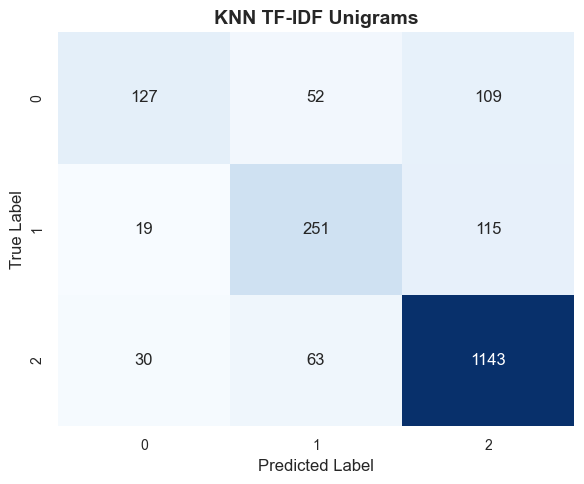

In [33]:
plot_confusion_matrix(y_val, y_val_pred_tfidf_unigrams, title=title, labels=[0, 1, 2], cmap="Blues")

### **2.2.2** Bigrams

In [34]:
modelknn = KNeighborsClassifier(n_neighbors = n_neighbors, metric = metric, weights = weights)

X_tfidf_bigrams, y_train_pred_tfidf_bigrams, y_val_pred_tfidf_bigrams, tfidf_bigrams = embedding_tfidf(x_train=x_train, y_train=y_train, x_val=x_val, max_df=max_df, min_df=min_df, model=modelknn, ngram_range=(1,2))

In [35]:
tfidf_bigrams.get_feature_names_out()

array(['aa', 'aa cc', 'aal', ..., 'zynga', 'zynga nasdaq', 'zynga share'],
      dtype=object)

In [36]:
tfidf_bigrams.vocabulary_

{'nasdaq': 31085,
 'price': 36890,
 'percent': 34823,
 'senior': 42701,
 'note': 32388,
 'nasdaq price': 31170,
 'price percent': 36953,
 'percent percent': 34991,
 'percent senior': 35033,
 'senior note': 42714,
 'future': 19119,
 'up': 52473,
 'future up': 19165,
 'november': 32471,
 'nonfarm': 32165,
 'private': 37096,
 'payroll': 34632,
 'consensus': 10002,
 'ticker_econx': 49076,
 'november nonfarm': 32484,
 'nonfarm private': 32167,
 'private payroll': 37106,
 'payroll consensus': 34633,
 'consensus ticker_econx': 10018,
 'twitter': 51843,
 'user': 53220,
 'explain': 16650,
 'kohl': 25802,
 'stock': 45478,
 'got': 20377,
 'obliterated': 32808,
 'reporting': 39689,
 'earnings': 14498,
 'twitter user': 51860,
 'user explain': 53223,
 'explain kohl': 16651,
 'kohl stock': 25813,
 'stock got': 45552,
 'got obliterated': 20380,
 'obliterated reporting': 32809,
 'reporting earnings': 39691,
 'agilysys': 927,
 'restaurant': 39970,
 'find': 17827,
 'sustainable': 46723,
 'method': 29581,

In [37]:
# get the IDF score for each term
idf_dict = dict(zip(tfidf_bigrams.get_feature_names_out(), tfidf_bigrams.idf_))

# Get the first 10 items
idf_dict_10 = dict(list(idf_dict.items())[4100:4110])

print(idf_dict_10)

{'bayer': 8.330536264855532, 'bayer asks': 9.246826996729688, 'bayer face': 9.246826996729688, 'bayer plaintiff': 9.246826996729688, 'bayer seek': 9.246826996729688, 'bayer stock': 9.246826996729688, 'bayway': 9.246826996729688, 'bayway refinery': 9.246826996729688, 'bazooka': 8.841361888621524, 'bazooka soothes': 9.246826996729688}


In [38]:
title = "KNN TF-IDF Bigrams"

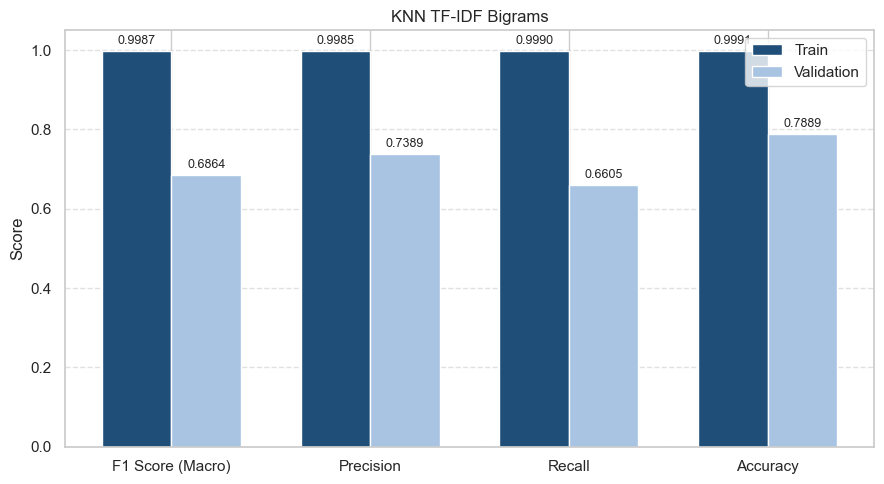

In [39]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_tfidf_bigrams, y_val, y_val_pred_tfidf_bigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_tfidf_bigrams, y_val, y_val_pred_tfidf_bigrams, title=title)

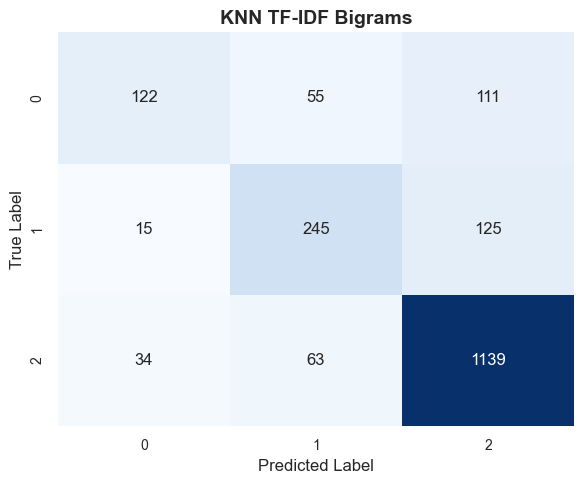

In [40]:
plot_confusion_matrix(y_val, y_val_pred_tfidf_bigrams, title=title, labels=[0, 1, 2], cmap="Blues")

## **2.3** Word2Vec

### **2.3.1** Minimum count = 1

In [41]:
modelknn = KNeighborsClassifier(n_neighbors = n_neighbors, metric = metric, weights = weights)

X_train_vec, y_train_pred_vec, y_val_pred_vec = embedding_word2vec(x_train=x_train, y_train=y_train, x_val=x_val, window=window, min_count=min_count, model=modelknn)

In [42]:
title = "KNN Word2Vec"

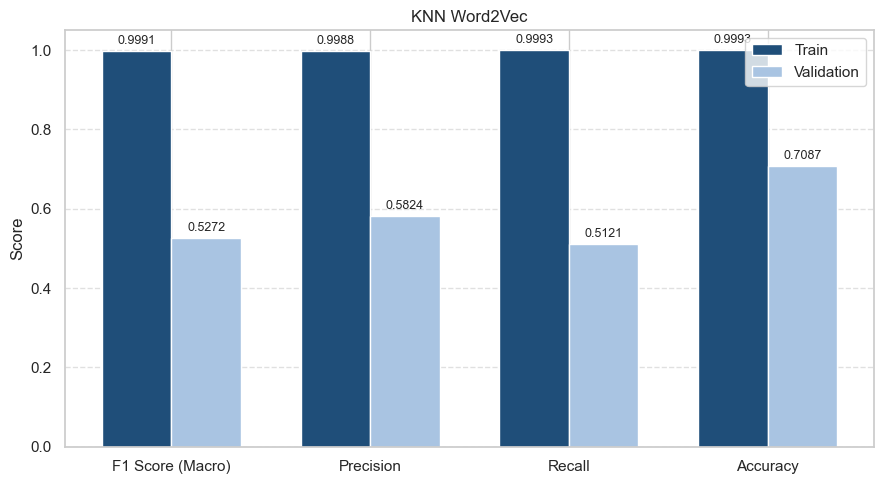

In [43]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_vec, y_val, y_val_pred_vec))

# Plot metrics
plot_metrics(y_train, y_train_pred_vec, y_val, y_val_pred_vec, title=title)

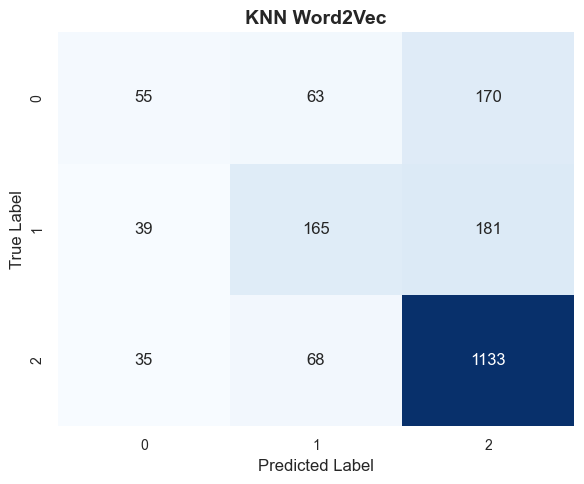

In [44]:
plot_confusion_matrix(y_val, y_val_pred_vec, title=title, labels=[0, 1, 2], cmap="Blues")

### **2.3.2** Minimum count based on percentile

In [45]:
tokenized_train = [word_tokenize(tweet.lower()) for tweet in x_train['text']]
all_tokens = [word for tweet in tokenized_train for word in tweet]

# frequency of each word
word_freq = Counter(all_tokens)
freq_values = np.array(list(word_freq.values()))

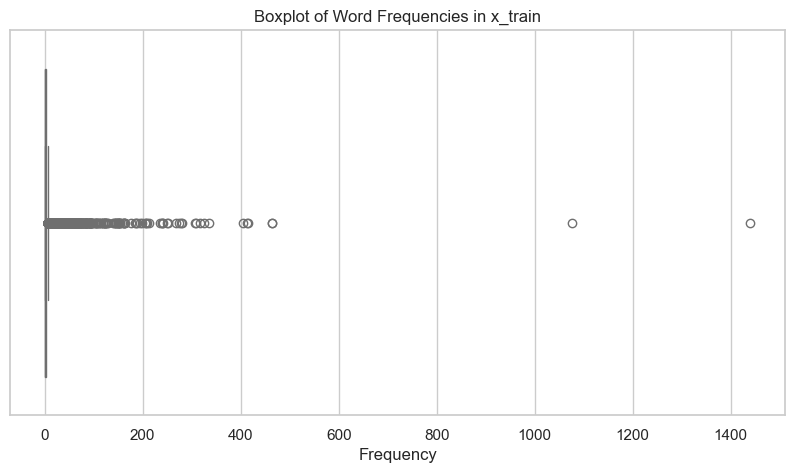

In [46]:
# boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x=freq_values, color='skyblue')
plt.title("Boxplot of Word Frequencies in x_train")
plt.xlabel("Frequency")
plt.show()

In [47]:
# 75th percentile
percentile_75 = int(np.percentile(freq_values, 75))

print(f"75th percentile: {percentile_75}")

75th percentile: 3


In [48]:
modelknn = KNeighborsClassifier(n_neighbors = n_neighbors, metric = metric, weights = weights)

X_train_vec, y_train_pred_vec, y_val_pred_vec = embedding_word2vec(x_train=x_train, y_train=y_train, x_val=x_val, window=window, min_count=percentile_75, model=modelknn)

In [49]:
title = "KNN Word2Vec - Min count = 75th percentile"

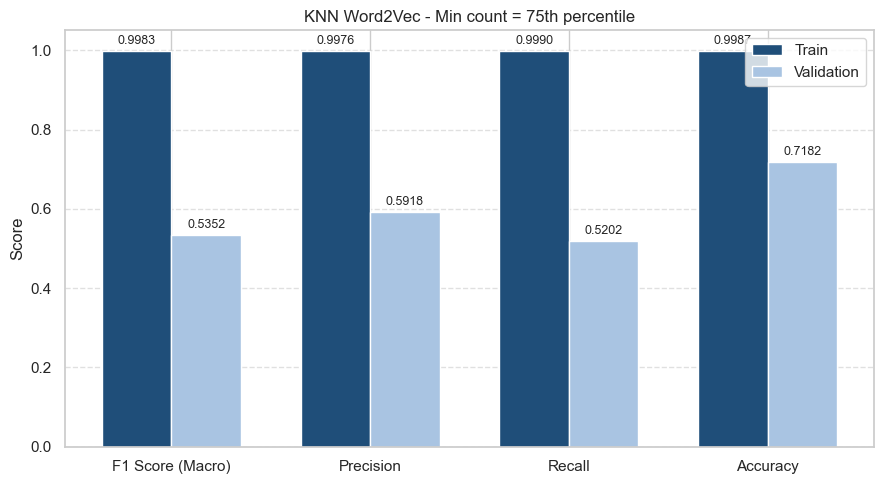

In [50]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_vec, y_val, y_val_pred_vec))

# Plot metrics
plot_metrics(y_train, y_train_pred_vec, y_val, y_val_pred_vec, title=title)

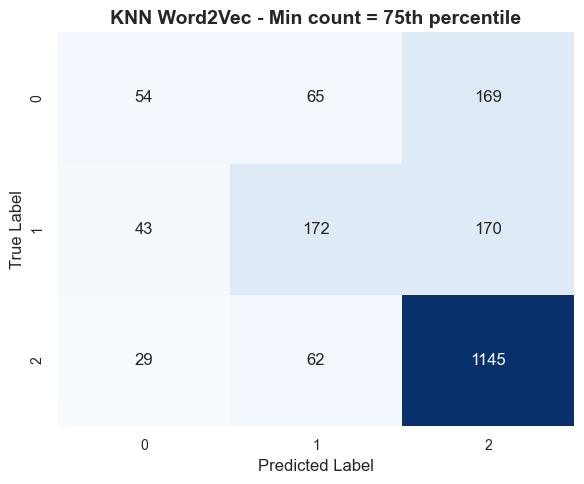

In [51]:
plot_confusion_matrix(y_val, y_val_pred_vec, title=title, labels=[0, 1, 2], cmap="Blues")

## **2.4** Glove

In [52]:
modelknn = KNeighborsClassifier(n_neighbors = n_neighbors, metric = metric, weights = weights)

X_train_glove_avg, y_train_pred_glove, y_val_pred_glove = embedding_glove(x_train=x_train, y_train=y_train, x_val=x_val, model_glove = glove_model, emb_size=emb_size, model=modelknn)

100%|██████████| 1909/1909 [00:00<00:00, 26669.49it/s]


In [53]:
title = "KNN Glove"

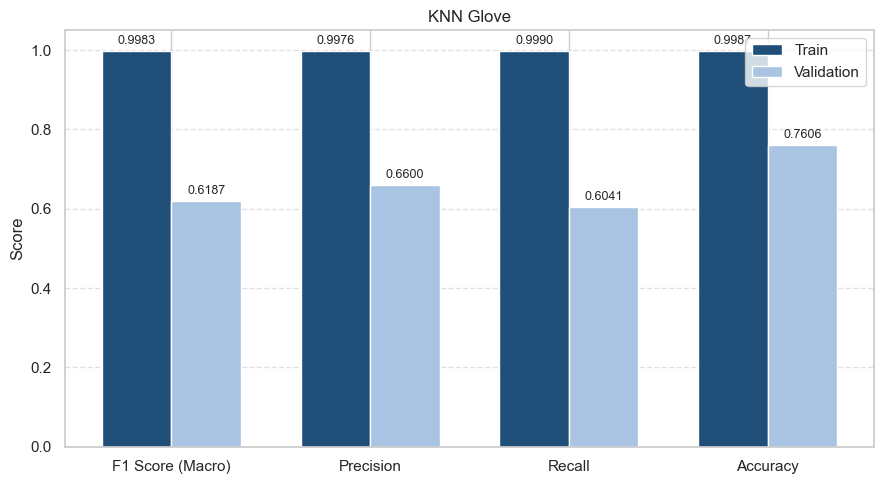

In [54]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_glove, y_val, y_val_pred_glove))

# Plot metrics
plot_metrics(y_train, y_train_pred_glove, y_val, y_val_pred_glove, title=title)

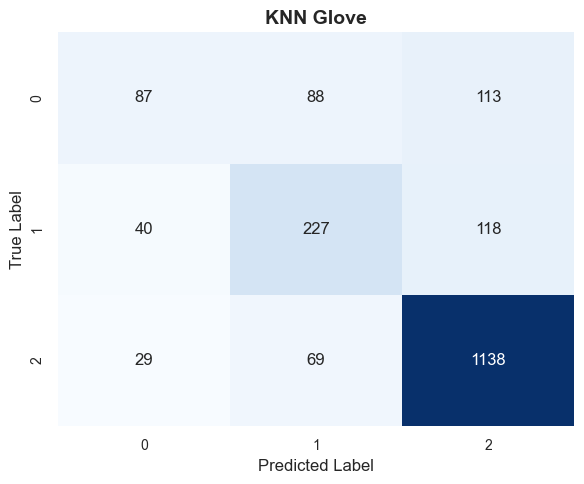

In [55]:
plot_confusion_matrix(y_val, y_val_pred_glove, title=title, labels=[0, 1, 2], cmap="Blues")

## **2.5** Text Embedding 3 Small - EXTRA

In [56]:
modelknn = KNeighborsClassifier(n_neighbors = n_neighbors, metric = metric, weights = weights)

X_train_te3s, y_train_pred_te3s,y_val_pred_te3s = embedding_te3s(train_texts=train_texts,
                                                                 train_labels=train_labels,
                                                                 val_texts = val_texts, 
                                                                 cache_file_train="X_train_te3s_embeddings.pkl", 
                                                                 cache_file_val="X_val_te3s_embeddings.pkl",
                                                                 client=client,
                                                                 model_te3s=model_te3s,
                                                                 batch_size=32,
                                                                 model=modelknn)

Loading embeddings from X_train_te3s_embeddings.pkl...
Loading embeddings from X_val_te3s_embeddings.pkl...


In [57]:
# Define the title for the metrics and plots
title = "KNN with Text Embedding 3 Small"

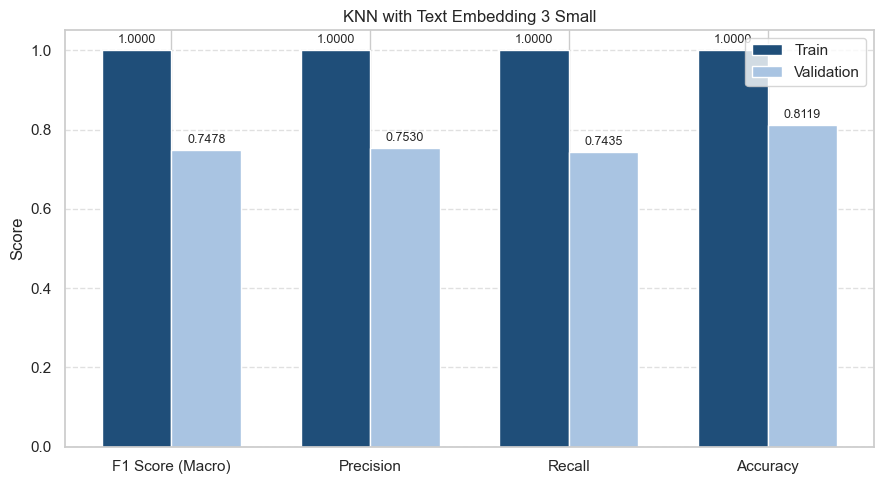

In [58]:
# Get metrics DataFrame
metrics_df.append(get_metrics_df(title, train_labels, y_train_pred_te3s, val_labels, y_val_pred_te3s))
metrics_df

# Plot metrics
plot_metrics(train_labels, y_train_pred_te3s, val_labels, y_val_pred_te3s, title=title)

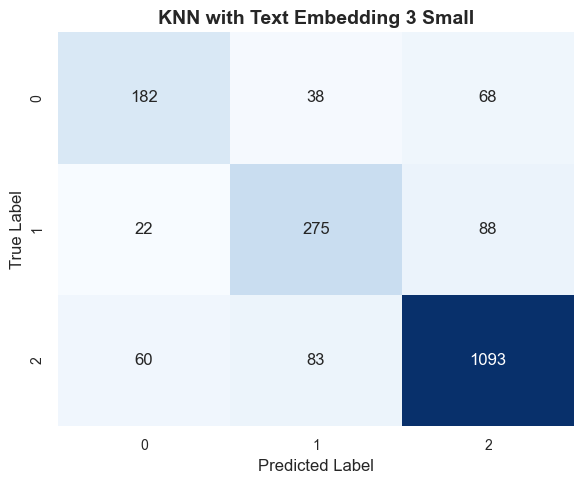

In [59]:
# Plot confusion matrix
plot_confusion_matrix(val_labels, y_val_pred_te3s, title=title, labels=[0, 1, 2], cmap="Blues")

## **2.6** Twitter Roberta Base - EXTRA

In [60]:
modelknn = KNeighborsClassifier(n_neighbors = n_neighbors, metric = metric, weights = weights)

X_train_roberta, y_train_pred_roberta,y_val_pred_roberta = embedding_roberta(train_texts=train_texts,
                                                                 train_labels=train_labels,
                                                                 val_texts = val_texts, 
                                                                 cache_file_train="X_train_roberta_embeddings.pkl", 
                                                                 cache_file_val="X_val_roberta_embeddings.pkl",
                                                                 tokenizer_roberta=tokenizer_roberta,
                                                                 model_roberta=model_roberta,
                                                                 batch_size=32,
                                                                 model=modelknn)

Loading RoBERTa embeddings from X_train_roberta_embeddings.pkl...
Loading RoBERTa embeddings from X_val_roberta_embeddings.pkl...


In [61]:
# Define the title for the metrics and plots
title = "KNN with RoBERTa"

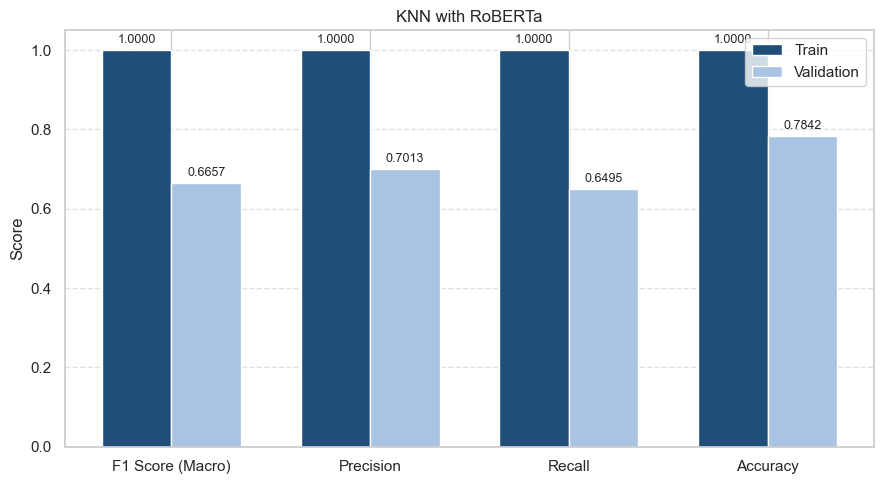

In [62]:
# Get metrics DataFrame
metrics_df.append(get_metrics_df(title, train_labels, y_train_pred_roberta, val_labels, y_val_pred_roberta))
metrics_df

# Plot metrics
plot_metrics(train_labels, y_train_pred_roberta, val_labels, y_val_pred_roberta, title=title)

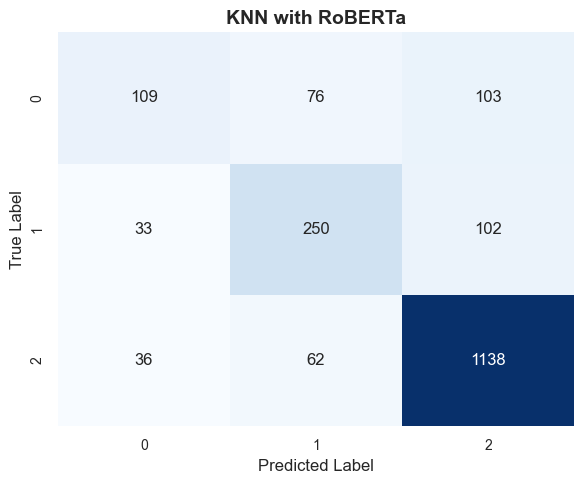

In [63]:
# Plot confusion matrix
plot_confusion_matrix(val_labels, y_val_pred_roberta, title=title, labels=[0, 1, 2], cmap="Blues")

<div class="alert alert-block alert-success">

# **3.** **Naive Bayes**

<div>

We didn't use Word2Vec, Glove or Extra because they generate numbers that can be negative and Naive Bayes is based on probabilities and word frequencies, which must be non-negative — negative values don’t make sense in this context and would cause errors during training.

## **3.1** Bag of Words

### **3.1.1** Unigrams

In [64]:
model_nb = MultinomialNB(alpha=alpha)

# each term is marked as present or not per document - good for short text
X_bow_unigrams, y_train_pred_bow_unigrams, y_val_pred_bow_unigrams, bow_unigrams = embedding_bow(x_train=x_train, y_train=y_train, x_val=x_val, max_df=max_df, min_df=min_df, model=model_nb)

In [65]:
title = "Naive Bayes BoW Unigrams"

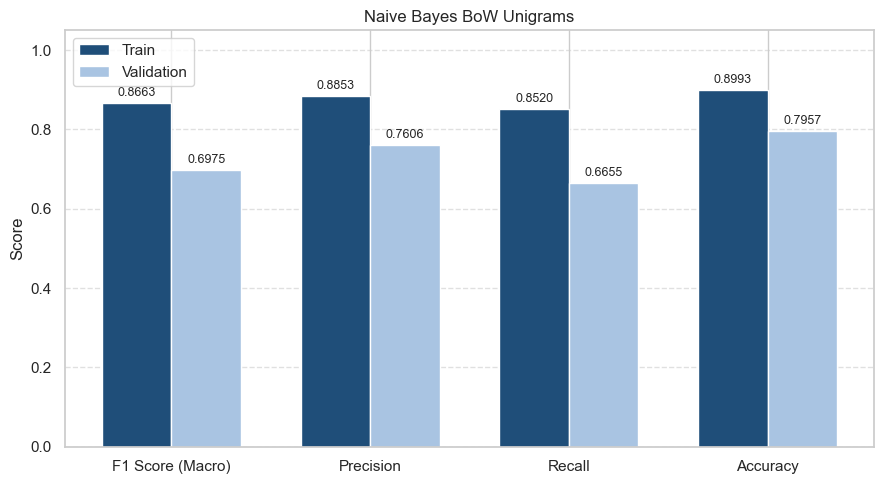

In [66]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_bow_unigrams, y_val, y_val_pred_bow_unigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_bow_unigrams, y_val, y_val_pred_bow_unigrams, title=title)

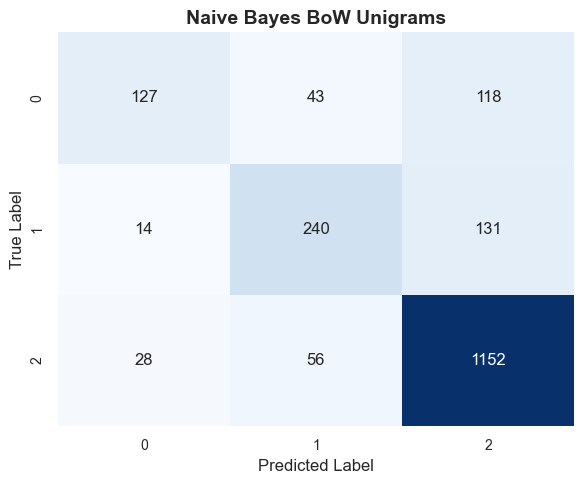

In [67]:
plot_confusion_matrix(y_val, y_val_pred_bow_unigrams, title=title, labels=[0, 1, 2], cmap="Blues")

### **3.1.2** Unigrams + Bigrams

In [68]:
model_nb = MultinomialNB(alpha=alpha)

X_bow_bigrams, y_train_pred_bow_bigrams, y_val_pred_bow_bigrams, bow_bigrams = embedding_bow(x_train=x_train, y_train=y_train, x_val=x_val, max_df=max_df, min_df=min_df, model=model_nb, ngram_range=(1,2))

In [69]:
title = "Naive Bayes BoW Bigrams"

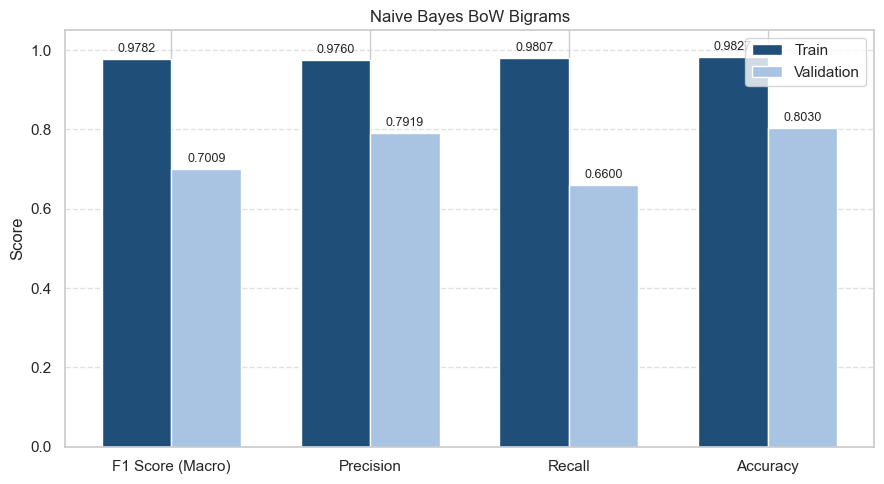

In [70]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_bow_bigrams, y_val, y_val_pred_bow_bigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_bow_bigrams, y_val, y_val_pred_bow_bigrams, title=title)

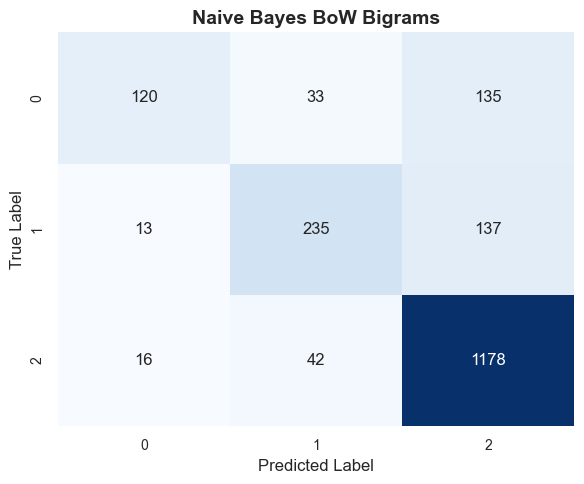

In [71]:
plot_confusion_matrix(y_val, y_val_pred_bow_bigrams, title=title, labels=[0, 1, 2], cmap="Blues")

## **3.2** TF-IDF

### **3.2.1** Unigrams

In [72]:
model_nb = MultinomialNB(alpha=alpha)

X_tfidf_unigrams, y_train_pred_tfidf_unigrams, y_val_pred_tfidf_unigrams, tfidf_unigrams = embedding_tfidf(x_train=x_train, y_train=y_train, x_val=x_val, max_df=max_df, min_df=min_df, model=model_nb)

In [73]:
title = "Naive Bayes TF-IDF Unigrams"

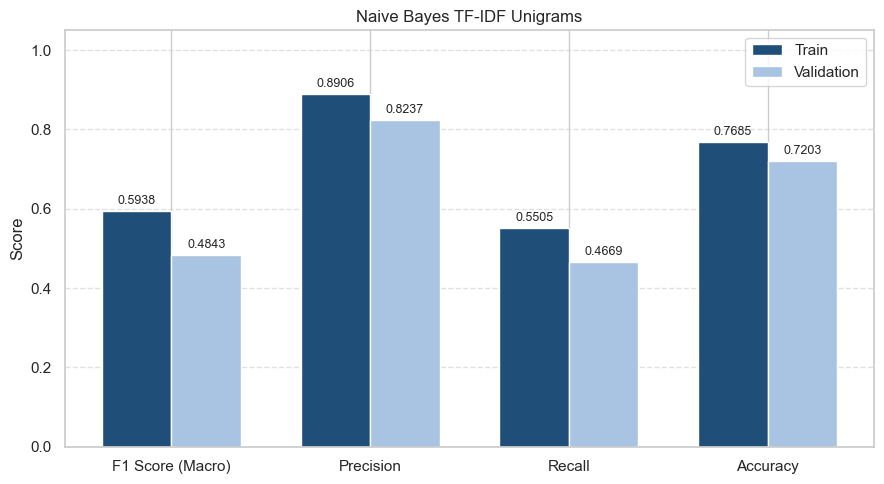

In [74]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_tfidf_unigrams, y_val, y_val_pred_tfidf_unigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_tfidf_unigrams, y_val, y_val_pred_tfidf_unigrams, title=title)

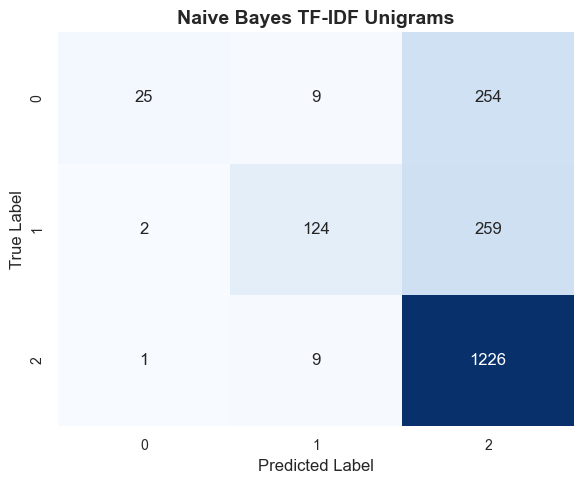

In [75]:
plot_confusion_matrix(y_val, y_val_pred_tfidf_unigrams, title=title, labels=[0, 1, 2], cmap="Blues")

### **3.2.2** Bigrams

In [76]:
model_nb = MultinomialNB(alpha=alpha)

X_tfidf_bigrams, y_train_pred_tfidf_bigrams, y_val_pred_tfidf_bigrams, tfidf_bigrams = embedding_tfidf(x_train=x_train, y_train=y_train, x_val=x_val, max_df=max_df, min_df=min_df, model=model_nb, ngram_range=(1,2))

In [77]:
title = "Naive Bayes TF-IDF Bigrams"

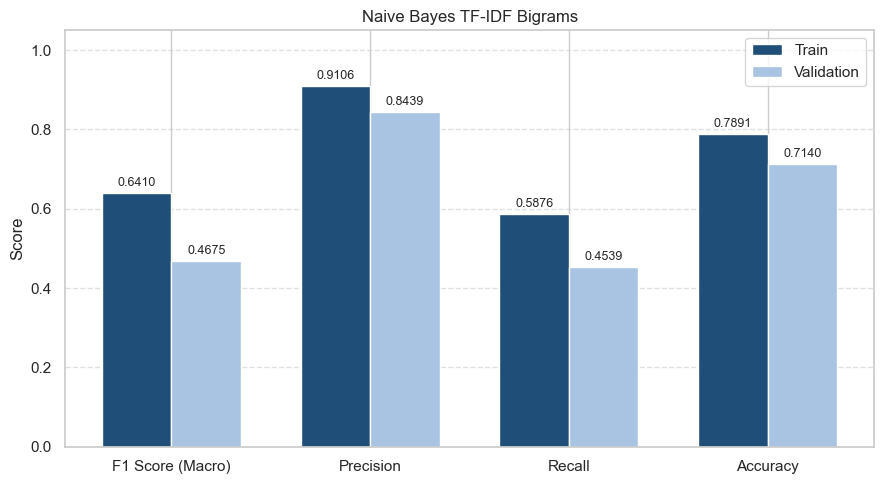

In [78]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_tfidf_bigrams, y_val, y_val_pred_tfidf_bigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_tfidf_bigrams, y_val, y_val_pred_tfidf_bigrams, title=title)

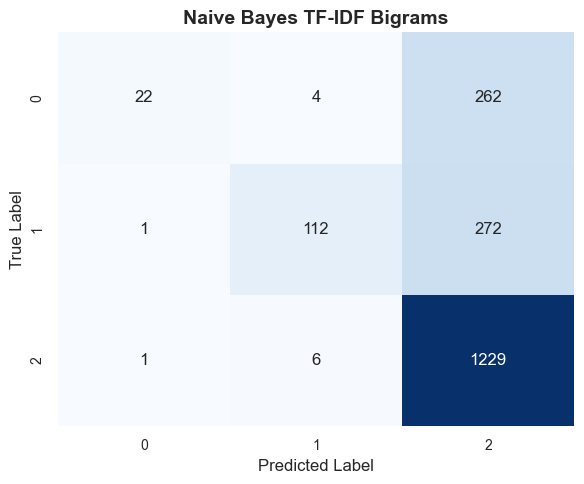

In [79]:
plot_confusion_matrix(y_val, y_val_pred_tfidf_bigrams, title=title, labels=[0, 1, 2], cmap="Blues")

<div class="alert alert-block alert-success">

# **4.** **Random Forest**

<div>

## **4.1** Bag of Words

### **4.1.1** Unigrams

In [80]:
model_rf = RandomForestClassifier(
    n_estimators=n_estimators,          
    criterion=criterion,         
    max_depth=max_depth,          
    min_samples_split=min_samples_split,      
    min_samples_leaf=min_samples_leaf,      
    max_features=max_features,
    class_weight=class_weight    
)

X_bow_unigrams, y_train_pred_bow_unigrams, y_val_pred_bow_unigrams, bow_unigrams = embedding_bow(x_train=x_train, y_train=y_train, x_val=x_val, max_df=max_df, min_df=min_df, model=model_rf)

In [81]:
title = "Random Forest BoW Unigrams"

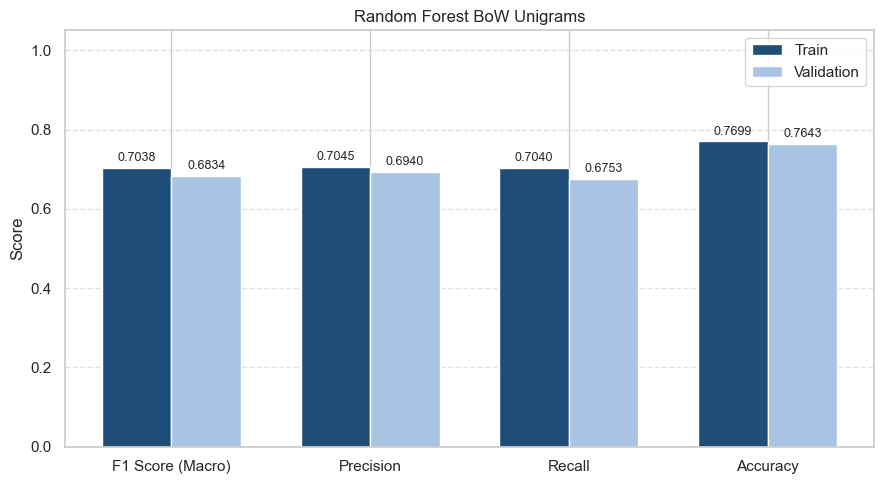

In [82]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_bow_unigrams, y_val, y_val_pred_bow_unigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_bow_unigrams, y_val, y_val_pred_bow_unigrams, title=title)

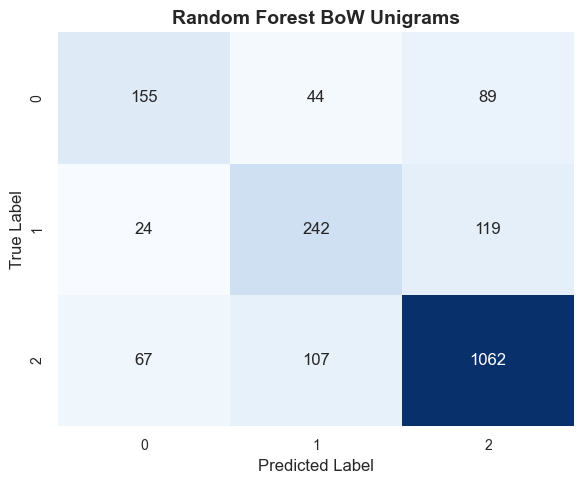

In [83]:
plot_confusion_matrix(y_val, y_val_pred_bow_unigrams, title=title, labels=[0, 1, 2], cmap="Blues")

### **4.1.2** Unigrams + Bigrams

In [84]:
model_rf = RandomForestClassifier(
    n_estimators=n_estimators,          
    criterion=criterion,         
    max_depth=max_depth,          
    min_samples_split=min_samples_split,      
    min_samples_leaf=min_samples_leaf,      
    max_features=max_features,
    class_weight=class_weight    
)

X_bow_bigrams, y_train_pred_bow_bigrams, y_val_pred_bow_bigrams, bow_bigrams = embedding_bow(x_train=x_train, y_train=y_train, x_val=x_val, max_df=max_df, min_df=min_df, model=model_rf, ngram_range=(1,2))

In [85]:
title = "Random Forest BoW Bigrams"

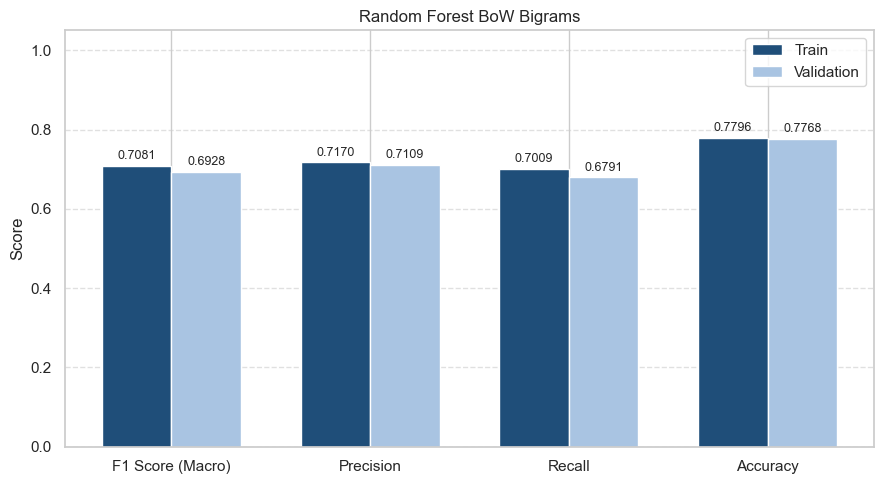

In [86]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_bow_bigrams, y_val, y_val_pred_bow_bigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_bow_bigrams, y_val, y_val_pred_bow_bigrams, title=title)

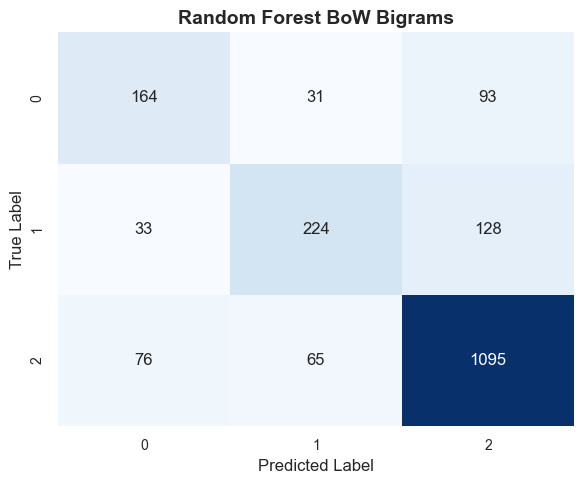

In [87]:
plot_confusion_matrix(y_val, y_val_pred_bow_bigrams, title=title, labels=[0, 1, 2], cmap="Blues")

## **4.2** TF-IDF

### **4.2.1** Unigrams

In [88]:
model_rf = RandomForestClassifier(
    n_estimators=n_estimators,          
    criterion=criterion,         
    max_depth=max_depth,          
    min_samples_split=min_samples_split,      
    min_samples_leaf=min_samples_leaf,      
    max_features=max_features,
    class_weight=class_weight    
)

X_tfidf_unigrams, y_train_pred_tfidf_unigrams, y_val_pred_tfidf_unigrams, tfidf_unigrams = embedding_tfidf(x_train=x_train, y_train=y_train, x_val=x_val, max_df=max_df, min_df=min_df, model=model_rf)

In [89]:
title = "Random Forest TF-IDF Unigrams"

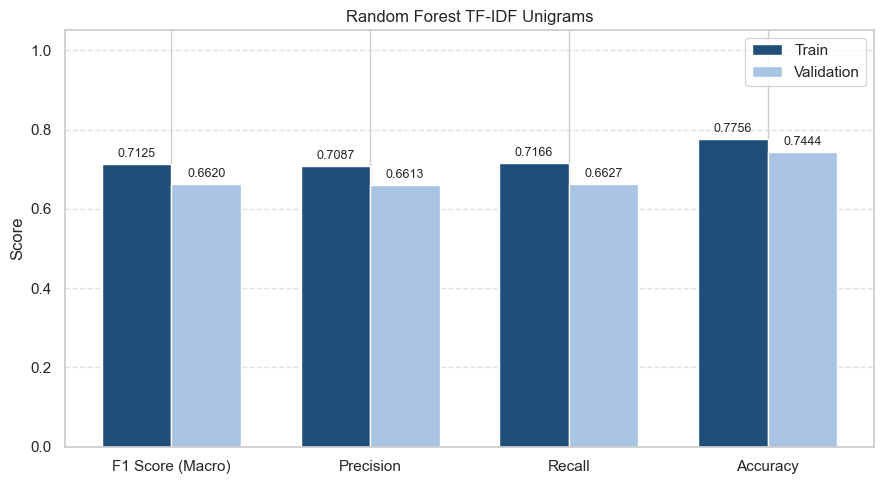

In [90]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_tfidf_unigrams, y_val, y_val_pred_tfidf_unigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_tfidf_unigrams, y_val, y_val_pred_tfidf_unigrams, title=title)

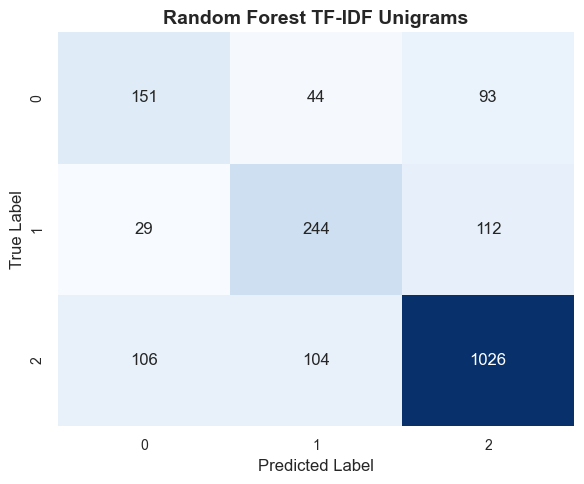

In [91]:
plot_confusion_matrix(y_val, y_val_pred_tfidf_unigrams, title=title, labels=[0, 1, 2], cmap="Blues")

### **4.2.2** Bigrams

In [92]:
model_rf = RandomForestClassifier(
    n_estimators=n_estimators,          
    criterion=criterion,         
    max_depth=max_depth,          
    min_samples_split=min_samples_split,      
    min_samples_leaf=min_samples_leaf,      
    max_features=max_features,
    class_weight=class_weight    
)

X_tfidf_bigrams, y_train_pred_tfidf_bigrams, y_val_pred_tfidf_bigrams, tfidf_bigrams = embedding_tfidf(x_train=x_train, y_train=y_train, x_val=x_val, max_df=max_df, min_df=min_df, model=model_rf, ngram_range=(1,2))

In [93]:
title = "Random Forest TF-IDF Bigrams"

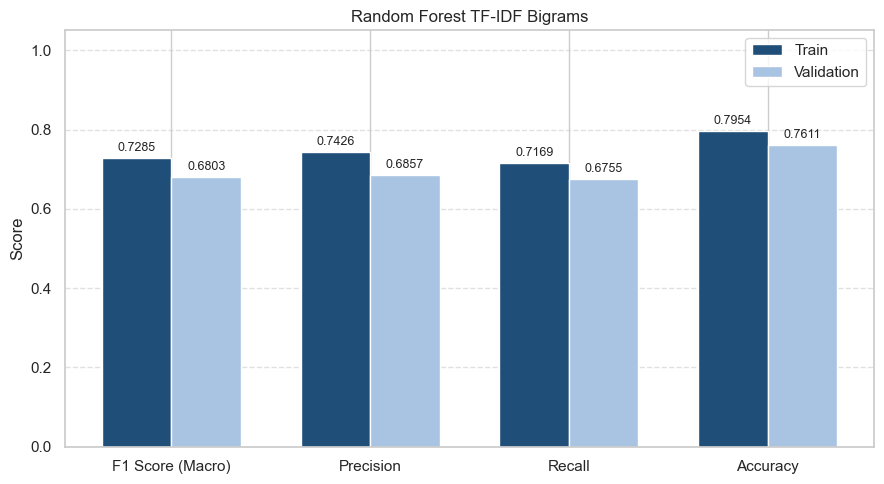

In [94]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_tfidf_bigrams, y_val, y_val_pred_tfidf_bigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_tfidf_bigrams, y_val, y_val_pred_tfidf_bigrams, title=title)

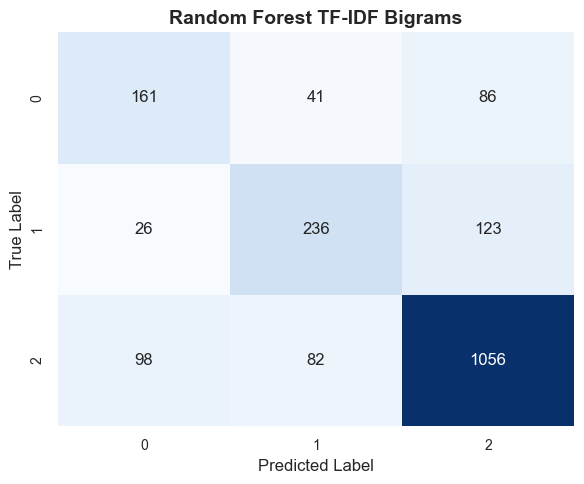

In [95]:
plot_confusion_matrix(y_val, y_val_pred_tfidf_bigrams, title=title, labels=[0, 1, 2], cmap="Blues")

## **4.3** Word2Vec

### **4.3.1** Minimum count = 1

In [96]:
model_rf = RandomForestClassifier(
    n_estimators=n_estimators,          
    criterion=criterion,         
    max_depth=max_depth,          
    min_samples_split=min_samples_split,      
    min_samples_leaf=min_samples_leaf,      
    max_features=max_features,
    class_weight=class_weight    
)

X_train_vec, y_train_pred_vec, y_val_pred_vec = embedding_word2vec(x_train=x_train, y_train=y_train, x_val=x_val, window=window, min_count=min_count, model=model_rf)

In [97]:
title = "Random Forest Word2Vec"

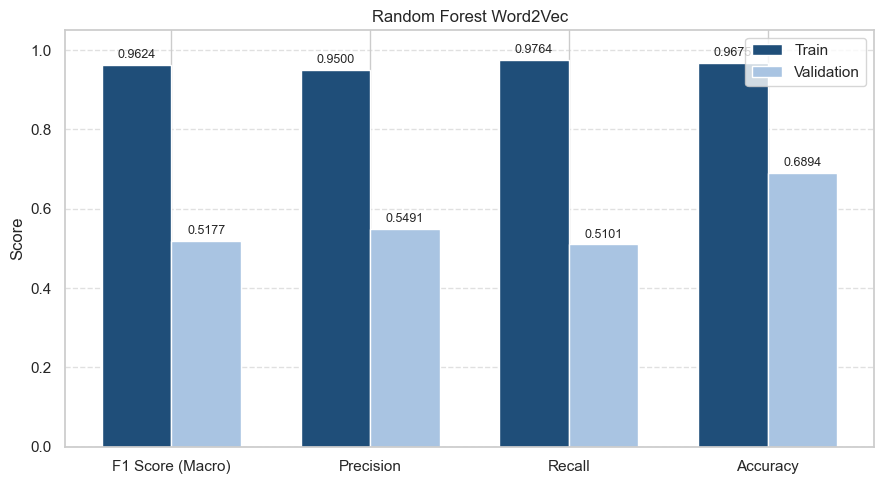

In [98]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_vec, y_val, y_val_pred_vec))

# Plot metrics
plot_metrics(y_train, y_train_pred_vec, y_val, y_val_pred_vec, title=title)

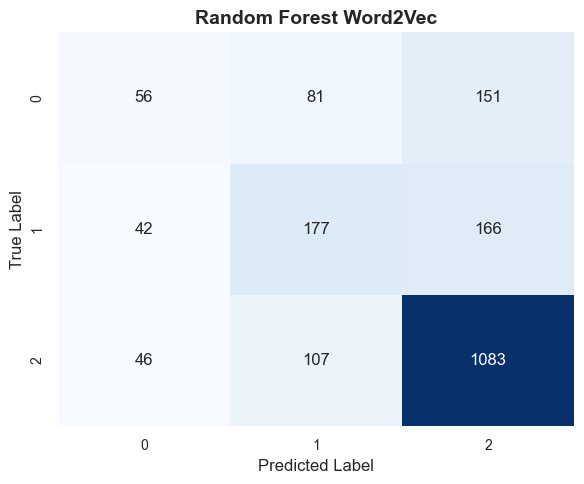

In [99]:
plot_confusion_matrix(y_val, y_val_pred_vec, title=title, labels=[0, 1, 2], cmap="Blues")

### **4.3.2** Minimum count based on percentile

In [100]:
model_rf = RandomForestClassifier(
    n_estimators=n_estimators,          
    criterion=criterion,         
    max_depth=max_depth,          
    min_samples_split=min_samples_split,      
    min_samples_leaf=min_samples_leaf,      
    max_features=max_features,
    class_weight=class_weight    
)

X_train_vec, y_train_pred_vec, y_val_pred_vec = embedding_word2vec(x_train=x_train, y_train=y_train, x_val=x_val, window=window, min_count=percentile_75, model=model_rf)

In [101]:
title = "Random Forest Word2Vec - Min count = 75th percentile"

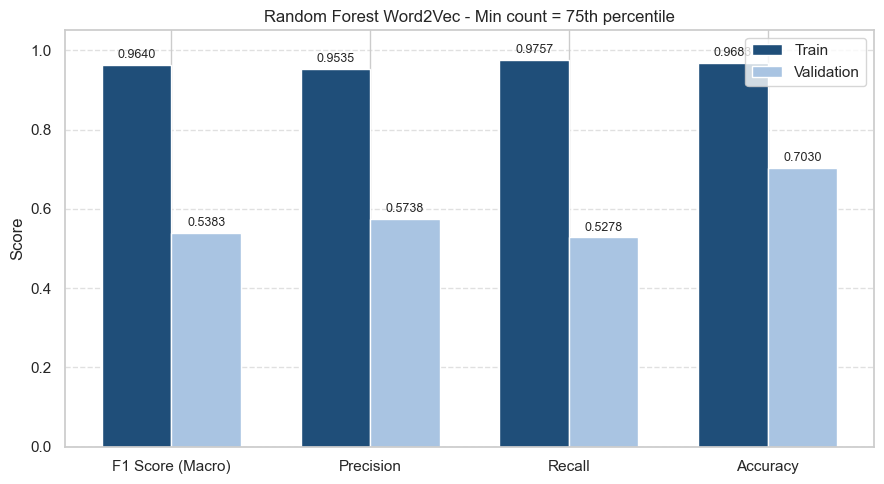

In [102]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_vec, y_val, y_val_pred_vec))

# Plot metrics
plot_metrics(y_train, y_train_pred_vec, y_val, y_val_pred_vec, title=title)

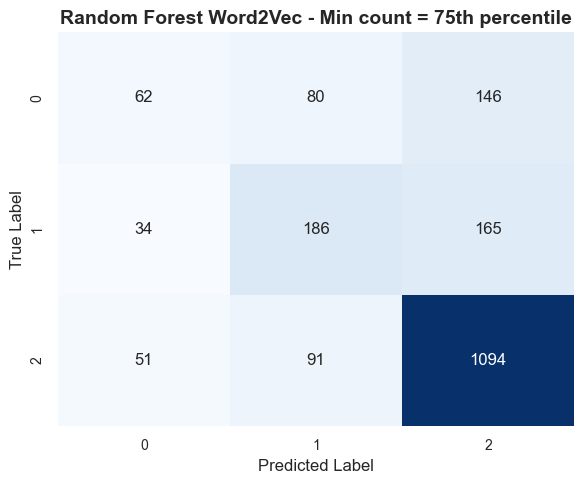

In [103]:
plot_confusion_matrix(y_val, y_val_pred_vec, title=title, labels=[0, 1, 2], cmap="Blues")

## **4.4** Glove

In [104]:
model_rf = RandomForestClassifier(
    n_estimators=n_estimators,          
    criterion=criterion,         
    max_depth=max_depth,          
    min_samples_split=min_samples_split,      
    min_samples_leaf=min_samples_leaf,      
    max_features=max_features,
    class_weight=class_weight    
)

X_train_glove_avg, y_train_pred_glove, y_val_pred_glove = embedding_glove(x_train=x_train, y_train=y_train, x_val=x_val, model_glove = glove_model, emb_size=emb_size, model=model_rf)

100%|██████████| 1909/1909 [00:00<00:00, 27384.41it/s]


In [105]:
title = "Random Forest Glove"

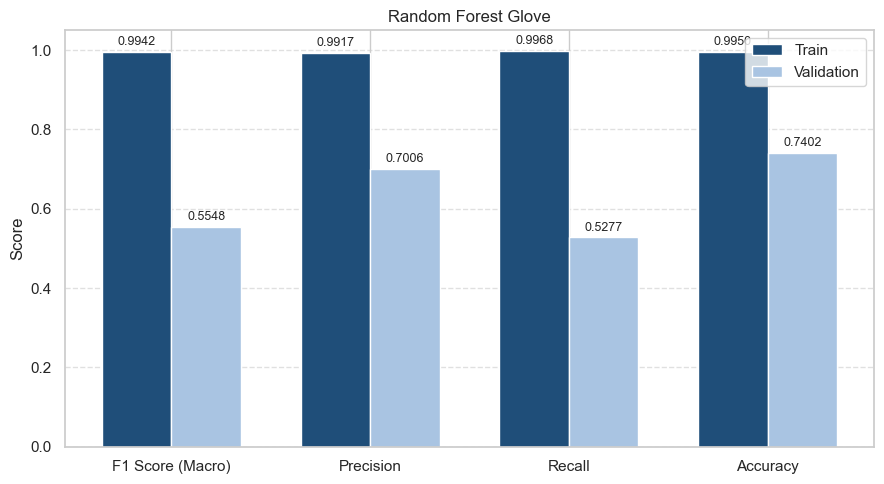

In [106]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_glove, y_val, y_val_pred_glove))

# Plot metrics
plot_metrics(y_train, y_train_pred_glove, y_val, y_val_pred_glove, title=title)

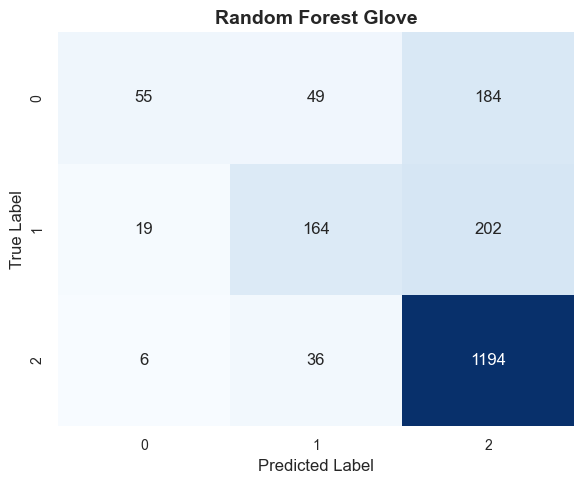

In [107]:
plot_confusion_matrix(y_val, y_val_pred_glove, title=title, labels=[0, 1, 2], cmap="Blues")

## **4.5** Text Embedding 3 Small - EXTRA

In [108]:
model_rf = RandomForestClassifier(
    n_estimators=n_estimators,          
    criterion=criterion,         
    max_depth=max_depth,          
    min_samples_split=min_samples_split,      
    min_samples_leaf=min_samples_leaf,      
    max_features=max_features,
    class_weight=class_weight    
)

X_train_te3s, y_train_pred_te3s,y_val_pred_te3s = embedding_te3s(train_texts=train_texts,
                                                                 train_labels=train_labels,
                                                                 val_texts = val_texts, 
                                                                 cache_file_train="X_train_te3s_embeddings.pkl", 
                                                                 cache_file_val="X_val_te3s_embeddings.pkl",
                                                                 client=client,
                                                                 model_te3s=model_te3s,
                                                                 batch_size=32,
                                                                 model=model_rf)

Loading embeddings from X_train_te3s_embeddings.pkl...
Loading embeddings from X_val_te3s_embeddings.pkl...


In [109]:
# Define the title for the metrics and plots
title = "Random Forest with Text Embedding 3 Small"

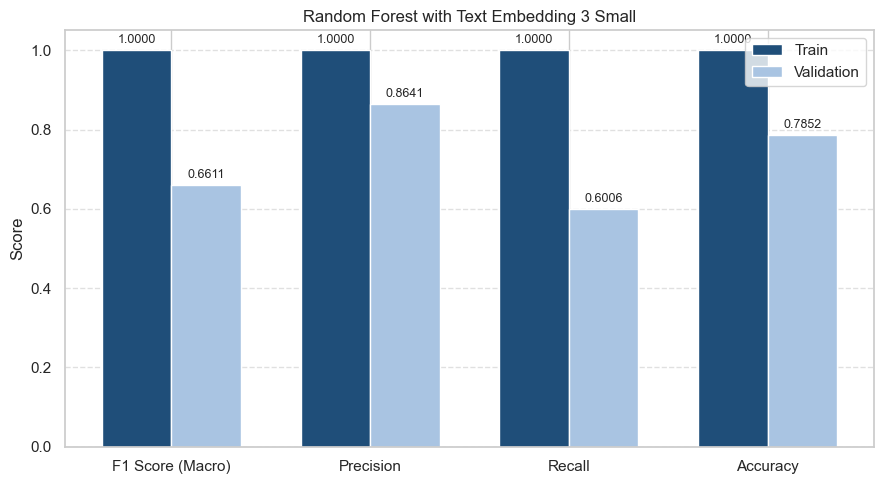

In [110]:
# Get metrics DataFrame
metrics_df.append(get_metrics_df(title, train_labels, y_train_pred_te3s, val_labels, y_val_pred_te3s))
metrics_df

# Plot metrics
plot_metrics(train_labels, y_train_pred_te3s, val_labels, y_val_pred_te3s, title=title)

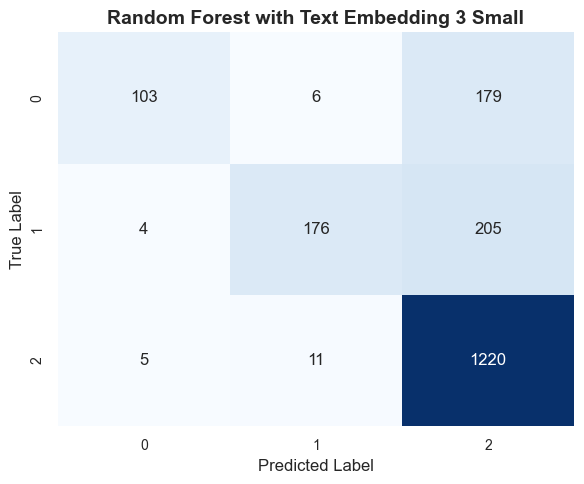

In [111]:
# Plot confusion matrix
plot_confusion_matrix(val_labels, y_val_pred_te3s, title=title, labels=[0, 1, 2], cmap="Blues")

## **4.6** Twitter Roberta Base - EXTRA

In [112]:
model_rf = RandomForestClassifier(
    n_estimators=n_estimators,          
    criterion=criterion,         
    max_depth=max_depth,          
    min_samples_split=min_samples_split,      
    min_samples_leaf=min_samples_leaf,      
    max_features=max_features,
    class_weight=class_weight    
)

X_train_roberta, y_train_pred_roberta,y_val_pred_roberta = embedding_roberta(train_texts=train_texts,
                                                                 train_labels=train_labels,
                                                                 val_texts = val_texts, 
                                                                 cache_file_train="X_train_roberta_embeddings.pkl", 
                                                                 cache_file_val="X_val_roberta_embeddings.pkl",
                                                                 tokenizer_roberta=tokenizer_roberta,
                                                                 model_roberta=model_roberta,
                                                                 batch_size=32,
                                                                 model=model_rf)

Loading RoBERTa embeddings from X_train_roberta_embeddings.pkl...
Loading RoBERTa embeddings from X_val_roberta_embeddings.pkl...


In [113]:
# Define the title for the metrics and plots
title = "Random Forest with RoBERTa"

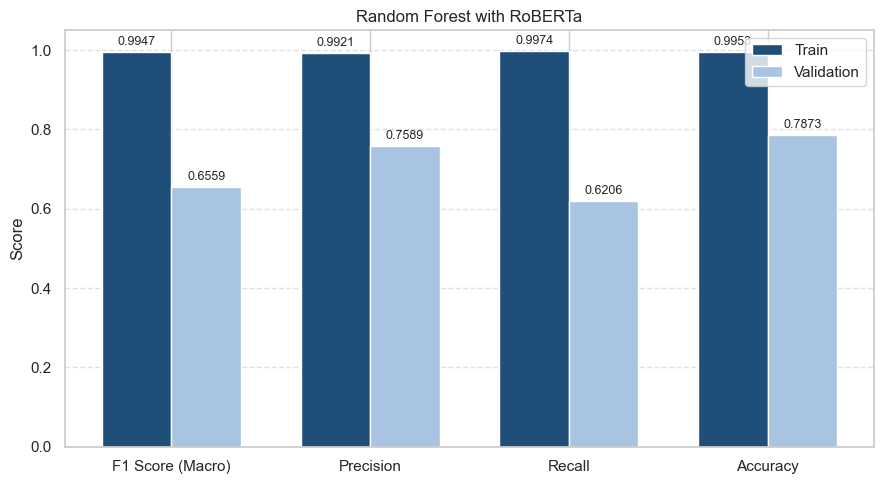

In [114]:
# Get metrics DataFrame
metrics_df.append(get_metrics_df(title, train_labels, y_train_pred_roberta, val_labels, y_val_pred_roberta))
metrics_df

# Plot metrics
plot_metrics(train_labels, y_train_pred_roberta, val_labels, y_val_pred_roberta, title=title)

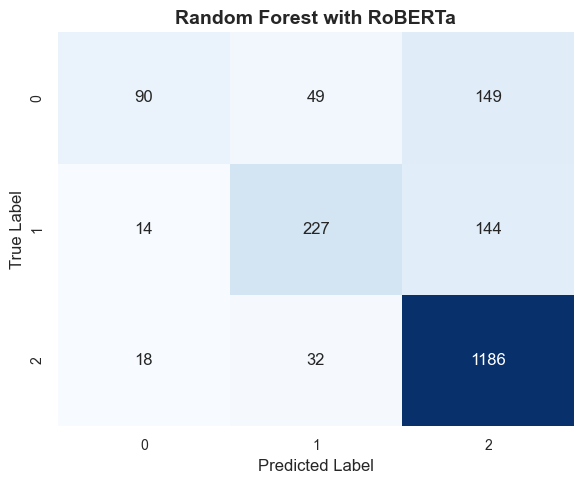

In [115]:
# Plot confusion matrix
plot_confusion_matrix(val_labels, y_val_pred_roberta, title=title, labels=[0, 1, 2], cmap="Blues")

<div class="alert alert-block alert-success">

# **5.** **Logistic Regression**

<div>

## **5.1** Bag of Words

### **5.1.1** Unigrams

In [116]:
model_lr = LogisticRegression(
    penalty=penalty, 
    solver=solver, 
    l1_ratio=l1_ratio, 
    C=C, 
    class_weight=class_weight, 
    max_iter=max_iter, 
    multi_class=multi_class
)

X_bow_unigrams, y_train_pred_bow_unigrams, y_val_pred_bow_unigrams, bow_unigrams = embedding_bow(x_train=x_train, y_train=y_train, x_val=x_val, max_df=max_df, min_df=min_df, model=model_lr)

In [117]:
title = "LR BoW Unigrams"

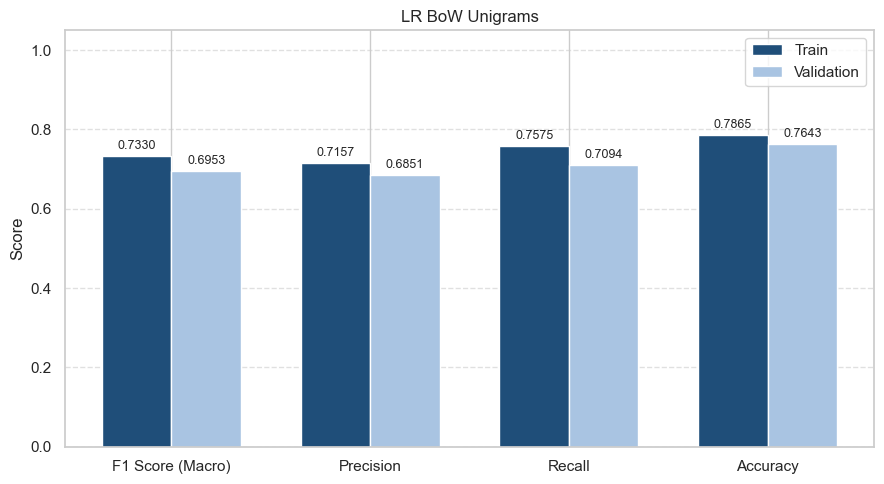

In [118]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_bow_unigrams, y_val, y_val_pred_bow_unigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_bow_unigrams, y_val, y_val_pred_bow_unigrams, title=title)

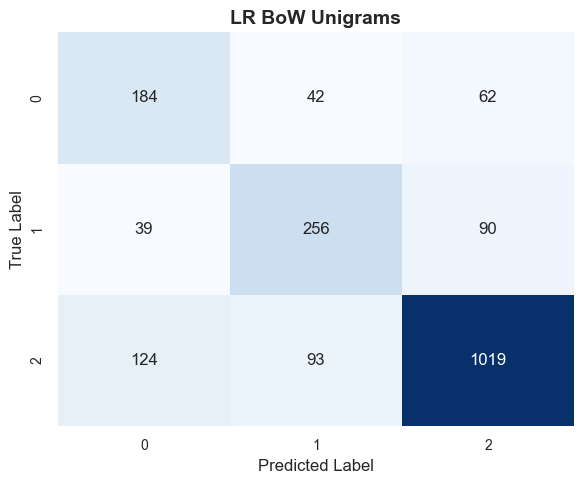

In [119]:
plot_confusion_matrix(y_val, y_val_pred_bow_unigrams, title=title, labels=[0, 1, 2], cmap="Blues")

### **5.1.2** Unigrams + Bigrams

In [120]:
model_lr = LogisticRegression(
    penalty=penalty, 
    solver=solver, 
    l1_ratio=l1_ratio, 
    C=C, 
    class_weight=class_weight, 
    max_iter=max_iter, 
    multi_class=multi_class
)

X_bow_bigrams, y_train_pred_bow_bigrams, y_val_pred_bow_bigrams, bow_bigrams = embedding_bow(x_train=x_train, y_train=y_train, x_val=x_val, model=model_lr, max_df=max_df, min_df=min_df, ngram_range=(1,2))

In [121]:
title = "LR BoW Bigrams"

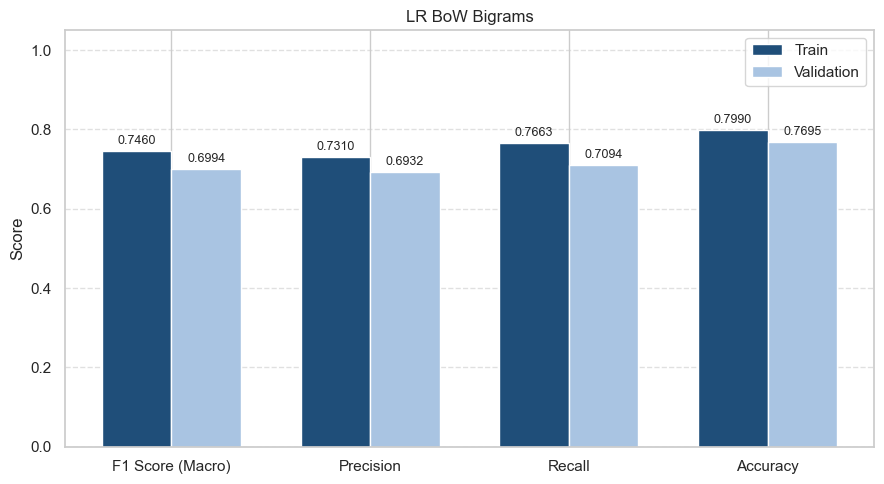

In [122]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_bow_bigrams, y_val, y_val_pred_bow_bigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_bow_bigrams, y_val, y_val_pred_bow_bigrams, title=title)

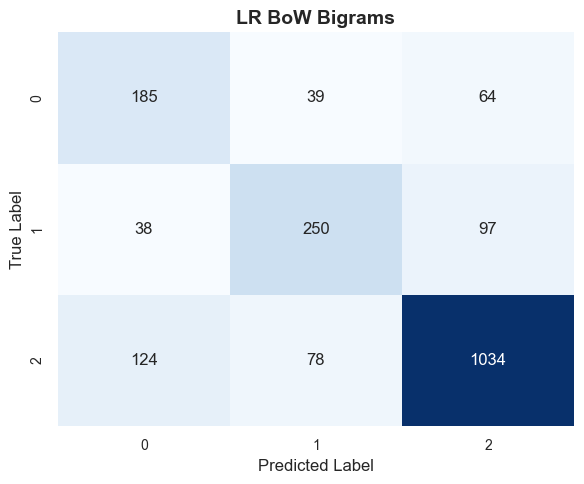

In [123]:
plot_confusion_matrix(y_val, y_val_pred_bow_bigrams, title=title, labels=[0, 1, 2], cmap="Blues")

## **5.2** TF-IDF

### **5.2.1** Unigrams

In [124]:
model_lr = LogisticRegression(
    penalty=penalty, 
    solver=solver, 
    l1_ratio=l1_ratio, 
    C=C, 
    class_weight=class_weight, 
    max_iter=max_iter, 
    multi_class=multi_class
)

X_tfidf_unigrams, y_train_pred_tfidf_unigrams, y_val_pred_tfidf_unigrams, tfidf_unigrams = embedding_tfidf(x_train=x_train, y_train=y_train, x_val=x_val, max_df=max_df, min_df=min_df, model=model_lr,oversampling_function=oversample)

In [125]:
title = "LR TF-IDF Unigrams"

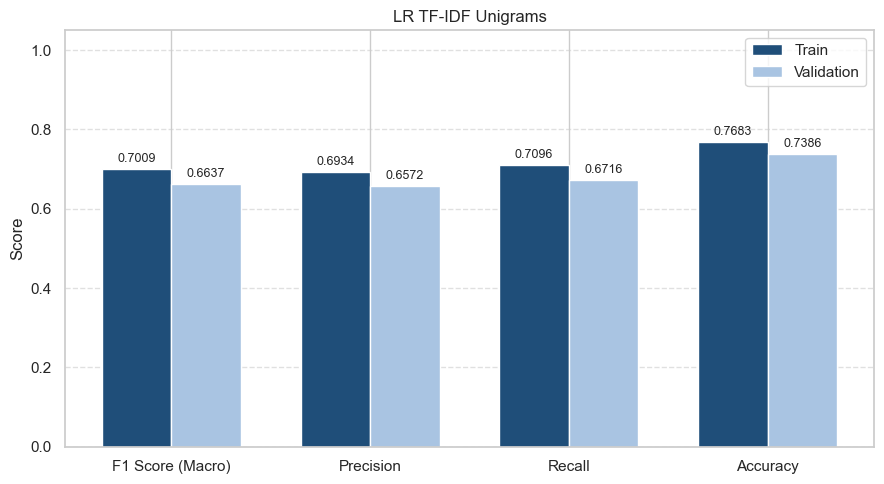

In [126]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_tfidf_unigrams, y_val, y_val_pred_tfidf_unigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_tfidf_unigrams, y_val, y_val_pred_tfidf_unigrams, title=title)

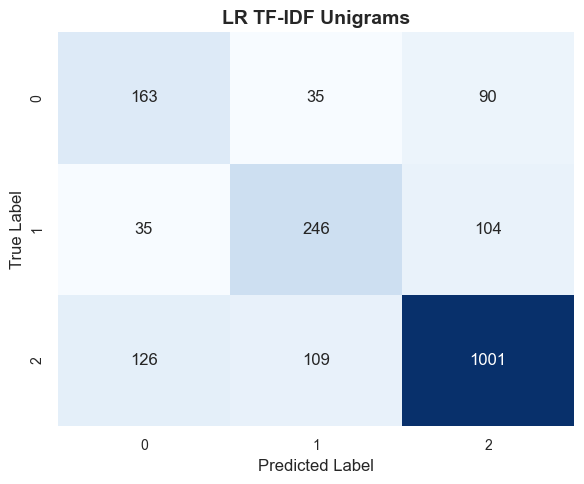

In [127]:
plot_confusion_matrix(y_val, y_val_pred_tfidf_unigrams, title=title, labels=[0, 1, 2], cmap="Blues")

### **5.2.2** Bigrams

In [128]:
model_lr = LogisticRegression(
    penalty=penalty, 
    solver=solver, 
    l1_ratio=l1_ratio, 
    C=C, 
    class_weight=class_weight, 
    max_iter=max_iter, 
    multi_class=multi_class
)

X_tfidf_bigrams, y_train_pred_tfidf_bigrams, y_val_pred_tfidf_bigrams, tfidf_bigrams = embedding_tfidf(x_train=x_train, y_train=y_train, x_val=x_val, max_df=max_df, min_df=min_df, model=model_lr, ngram_range=(1,2))

In [129]:
title = "LR TF-IDF Bigrams"

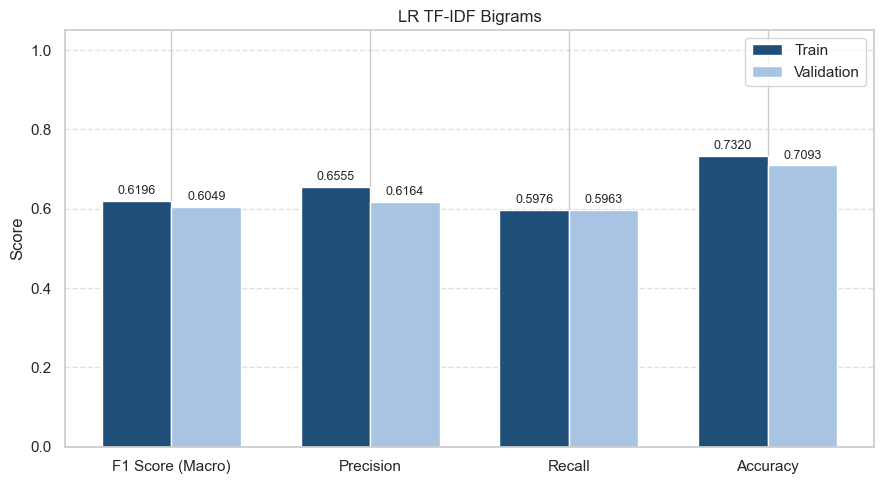

In [130]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_tfidf_bigrams, y_val, y_val_pred_tfidf_bigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_tfidf_bigrams, y_val, y_val_pred_tfidf_bigrams, title=title)

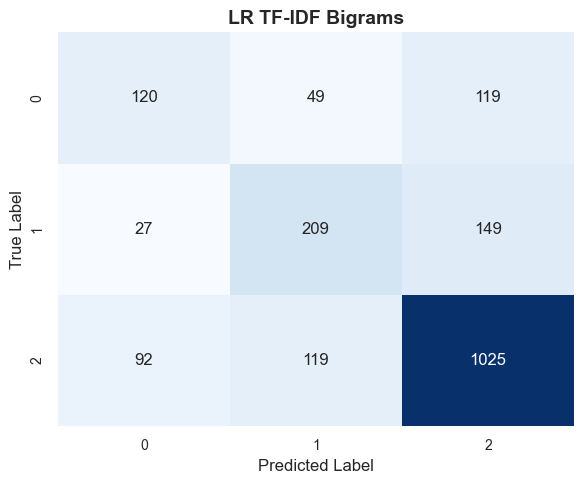

In [131]:
plot_confusion_matrix(y_val, y_val_pred_tfidf_bigrams, title=title, labels=[0, 1, 2], cmap="Blues")

## **5.3** Word2Vec

### **5.3.1** Minimum count = 1

In [132]:
model_lr = LogisticRegression(
    penalty=penalty, 
    solver=solver, 
    l1_ratio=l1_ratio, 
    C=C, 
    class_weight=class_weight, 
    max_iter=max_iter, 
    multi_class=multi_class
)

X_train_vec, y_train_pred_vec, y_val_pred_vec = embedding_word2vec(x_train=x_train, y_train=y_train, x_val=x_val, window=window, min_count=min_count, model=model_lr)

In [133]:
title = "LR Word2Vec"

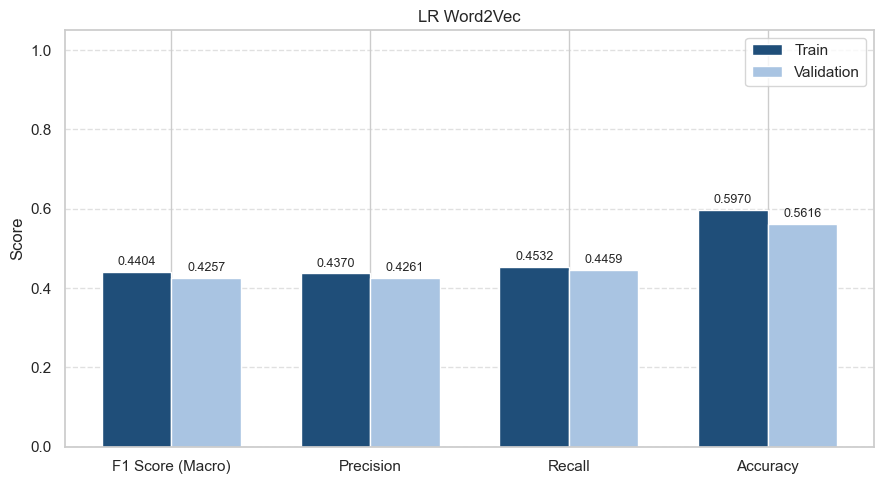

In [134]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_vec, y_val, y_val_pred_vec))

# Plot metrics
plot_metrics(y_train, y_train_pred_vec, y_val, y_val_pred_vec, title=title)

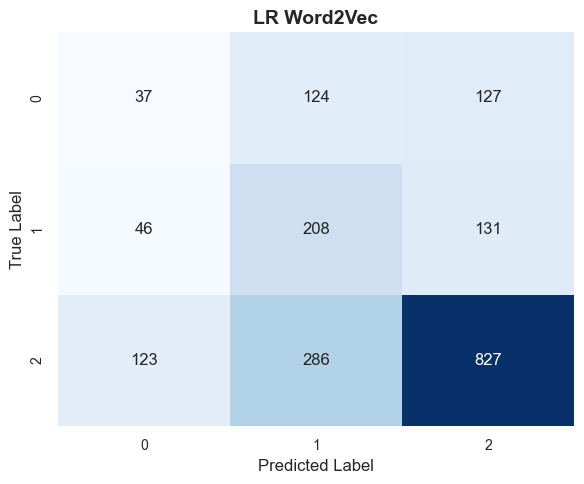

In [135]:
plot_confusion_matrix(y_val, y_val_pred_vec, title=title, labels=[0, 1, 2], cmap="Blues")

### **5.3.2** Minimum count based on percentile

In [136]:
X_train_vec, y_train_pred_vec, y_val_pred_vec = embedding_word2vec(x_train=x_train, y_train=y_train, x_val=x_val, window=window, min_count=percentile_75, model=model_lr)

In [137]:
title = "LR Word2Vec - Min count = 75th percentile"

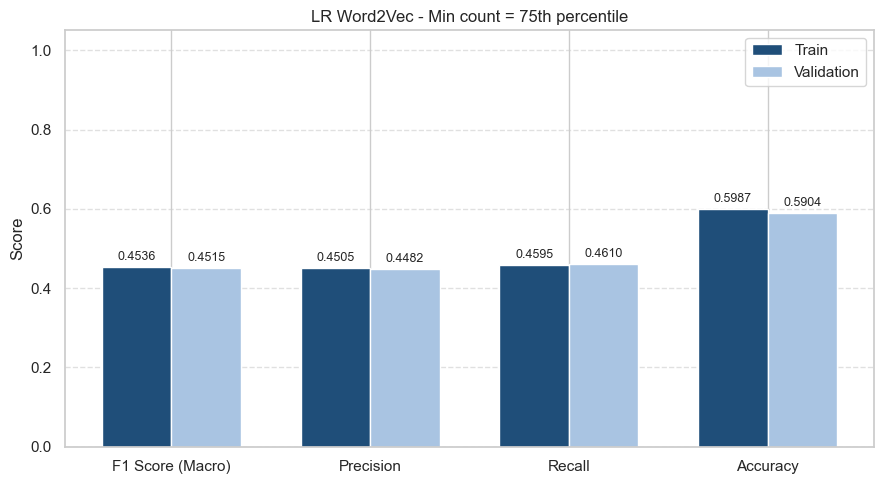

In [138]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_vec, y_val, y_val_pred_vec))

# Plot metrics
plot_metrics(y_train, y_train_pred_vec, y_val, y_val_pred_vec, title=title)

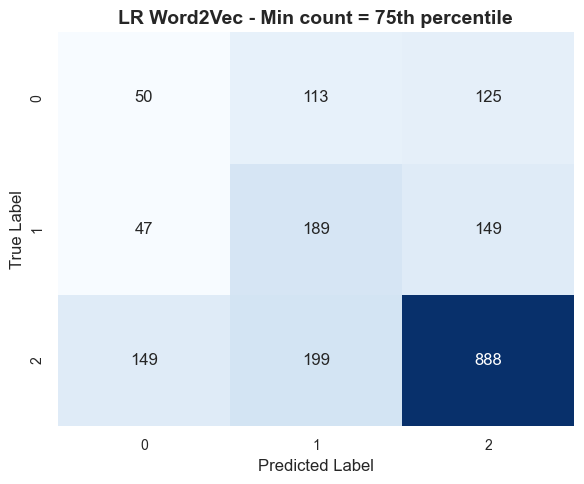

In [139]:
plot_confusion_matrix(y_val, y_val_pred_vec, title=title, labels=[0, 1, 2], cmap="Blues")

## **5.4** Glove

In [140]:
model_lr = LogisticRegression(
    penalty=penalty, 
    solver=solver, 
    l1_ratio=l1_ratio, 
    C=C, 
    class_weight=class_weight, 
    max_iter=max_iter, 
    multi_class=multi_class
)

X_train_glove_avg, y_train_pred_glove, y_val_pred_glove = embedding_glove(x_train=x_train, y_train=y_train, x_val=x_val, model_glove = glove_model, emb_size=emb_size, model=model_lr)

100%|██████████| 1909/1909 [00:00<00:00, 27006.81it/s]


In [141]:
title = "LR Glove"

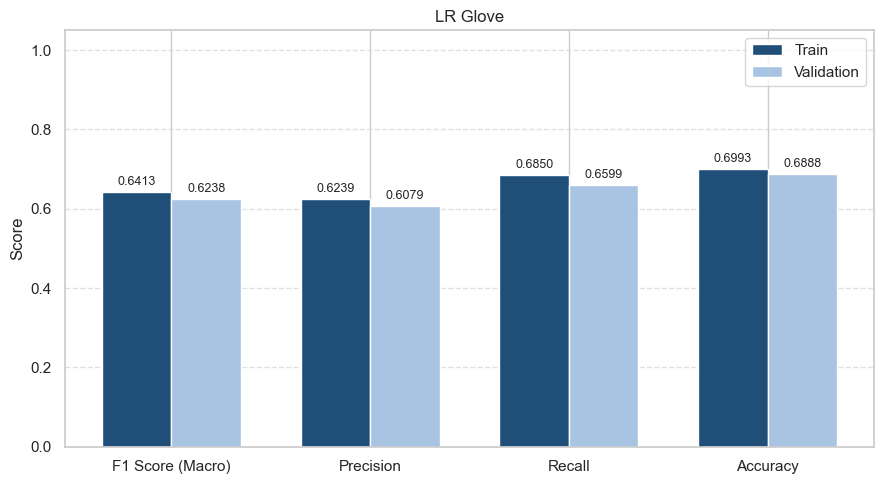

In [142]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_glove, y_val, y_val_pred_glove))

# Plot metrics
plot_metrics(y_train, y_train_pred_glove, y_val, y_val_pred_glove, title=title)

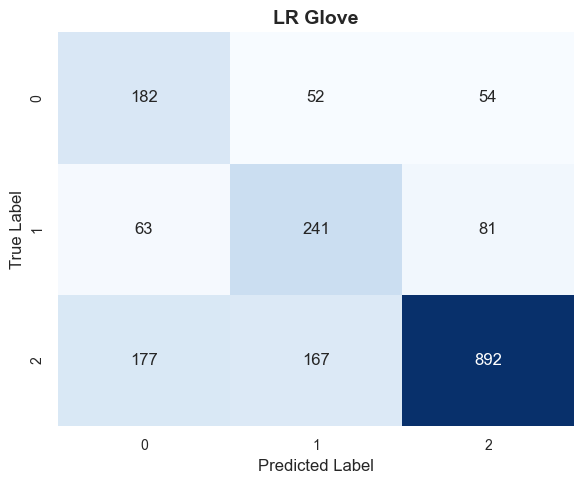

In [143]:
plot_confusion_matrix(y_val, y_val_pred_glove, title=title, labels=[0, 1, 2], cmap="Blues")

## **5.5** Text Embedding 3 Small - EXTRA

In [144]:
model_lr = LogisticRegression(
    penalty=penalty, 
    solver=solver, 
    l1_ratio=l1_ratio, 
    C=C, 
    class_weight=class_weight, 
    max_iter=max_iter, 
    multi_class=multi_class
)

X_train_te3s, y_train_pred_te3s,y_val_pred_te3s = embedding_te3s(train_texts=train_texts,
                                                                 train_labels=train_labels,
                                                                 val_texts = val_texts, 
                                                                 cache_file_train="X_train_te3s_embeddings.pkl", 
                                                                 cache_file_val="X_val_te3s_embeddings.pkl",
                                                                 client=client,
                                                                 model_te3s=model_te3s,
                                                                 batch_size=32,
                                                                 model=model_lr)

Loading embeddings from X_train_te3s_embeddings.pkl...
Loading embeddings from X_val_te3s_embeddings.pkl...


In [145]:
# Define the title for the metrics and plots
title = "Logistic Regression with Text Embedding 3 Small"

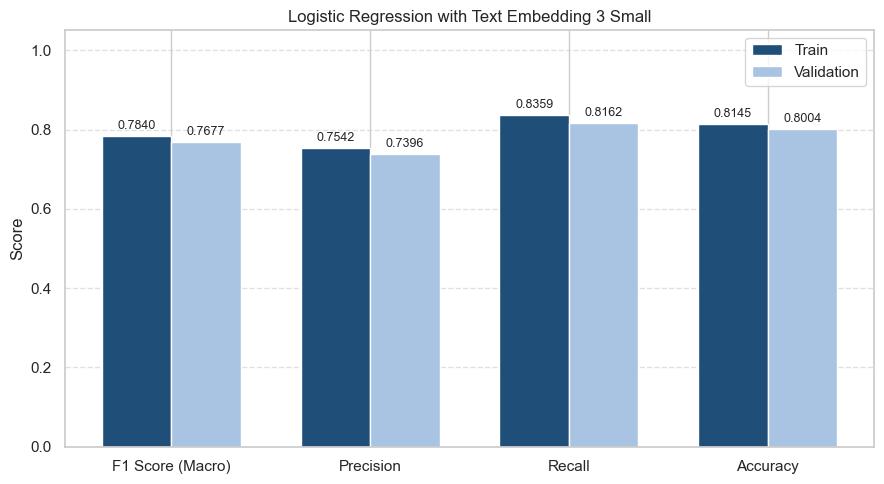

In [ ]:
# Get metrics DataFrame
metrics_df.append(get_metrics_df(title, train_labels, y_train_pred_te3s, val_labels, y_val_pred_te3s))
metrics_df

# Plot metrics
plot_metrics(train_labels, y_train_pred_te3s, val_labels, y_val_pred_te3s, title=title)

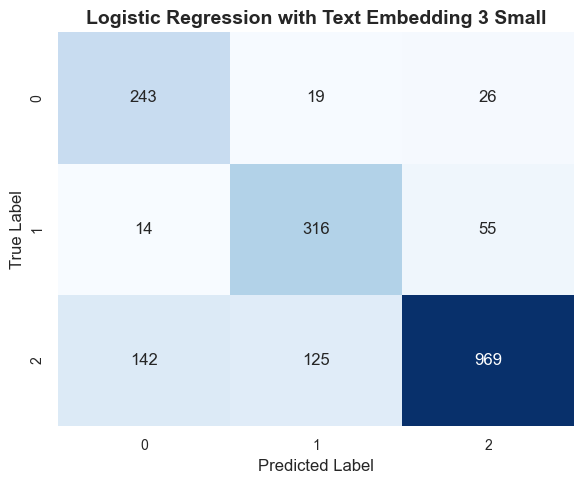

In [147]:
# Plot confusion matrix
plot_confusion_matrix(val_labels, y_val_pred_te3s, title=title, labels=[0, 1, 2], cmap="Blues")

## **5.6** Twitter Roberta Base - EXTRA

In [148]:
model_lr = LogisticRegression(
    penalty=penalty, 
    solver=solver, 
    l1_ratio=l1_ratio, 
    C=C, 
    class_weight=class_weight, 
    max_iter=max_iter, 
    multi_class=multi_class
)

X_train_roberta, y_train_pred_roberta,y_val_pred_roberta = embedding_roberta(train_texts=train_texts,
                                                                 train_labels=train_labels,
                                                                 val_texts = val_texts, 
                                                                 cache_file_train="X_train_roberta_embeddings.pkl", 
                                                                 cache_file_val="X_val_roberta_embeddings.pkl",
                                                                 tokenizer_roberta=tokenizer_roberta,
                                                                 model_roberta=model_roberta,
                                                                 batch_size=32,
                                                                 model=model_lr)

Loading RoBERTa embeddings from X_train_roberta_embeddings.pkl...
Loading RoBERTa embeddings from X_val_roberta_embeddings.pkl...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [149]:
# Define the title for the metrics and plots
title = "Logistic Regression with RoBERTa"

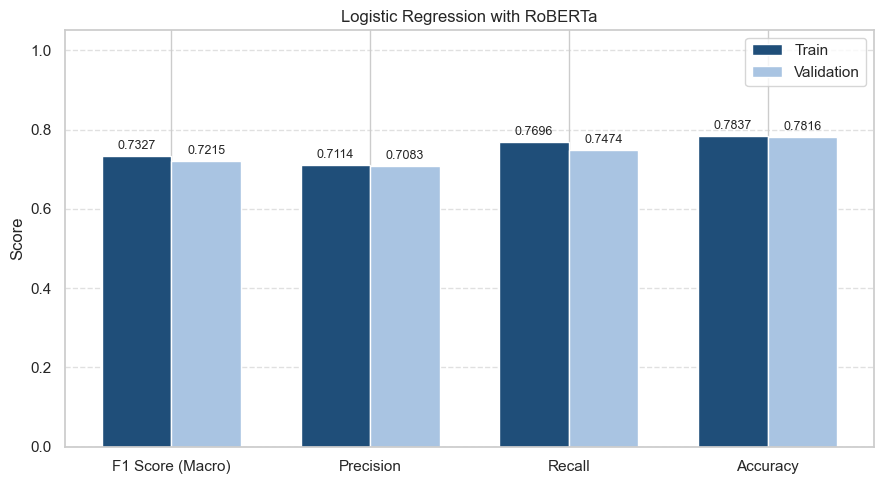

In [150]:
# Get metrics DataFrame
metrics_df.append(get_metrics_df(title, train_labels, y_train_pred_roberta, val_labels, y_val_pred_roberta))
metrics_df

# Plot metrics
plot_metrics(train_labels, y_train_pred_roberta, val_labels, y_val_pred_roberta, title=title)

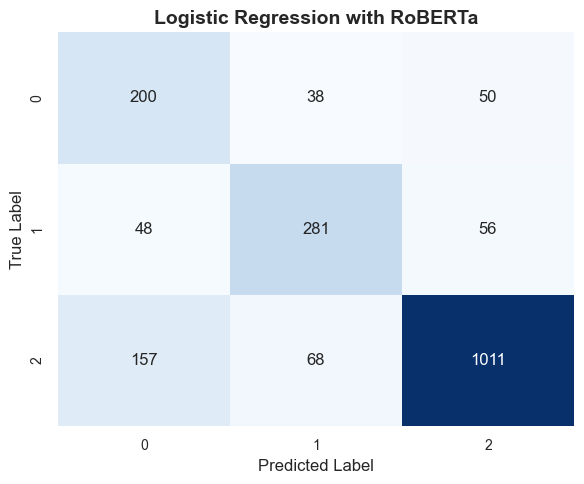

In [151]:
# Plot confusion matrix
plot_confusion_matrix(val_labels, y_val_pred_roberta, title=title, labels=[0, 1, 2], cmap="Blues")

<div class="alert alert-block alert-success">

# **6.** **XGBoost**

<div>

## **6.1** Bag of Words

### **6.1.1** Unigrams

In [152]:
model_xgb =  XGBClassifier(
    objective=objective, 
    num_class=num_class, 
    eval_metric=eval_metric, 
    learning_rate=0.8, 
    max_depth=max_depth_xgboost, 
    n_estimators=n_estimators, 
    subsample=subsample, 
    colsample_bytree=colsample_bytree,
    scale_pos_weight=scale_pos_weight
)

# each term is marked as present or not per document - good for short text
X_bow_unigrams, y_train_pred_bow_unigrams, y_val_pred_bow_unigrams, bow_unigrams = embedding_bow(x_train=x_train, y_train=y_train, x_val=x_val, max_df=max_df, min_df=min_df, model=model_xgb)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:43:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [153]:
title = "XGB BoW Unigrams"

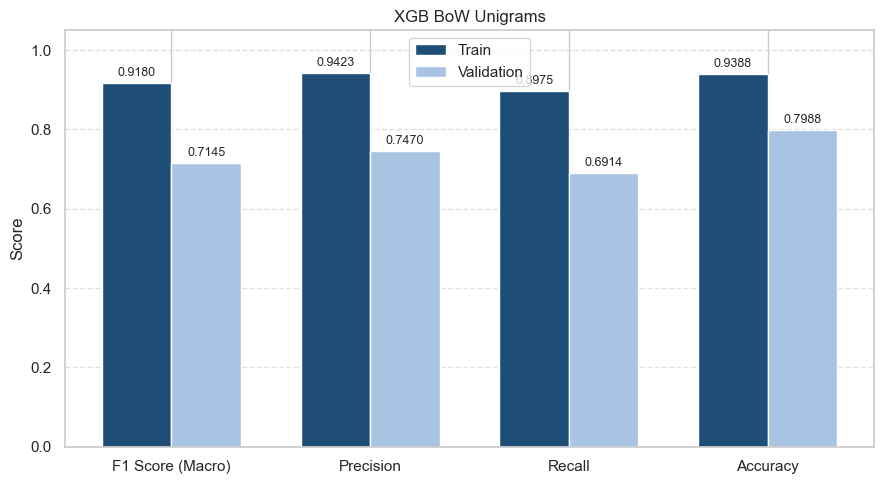

In [154]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_bow_unigrams, y_val, y_val_pred_bow_unigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_bow_unigrams, y_val, y_val_pred_bow_unigrams, title=title)

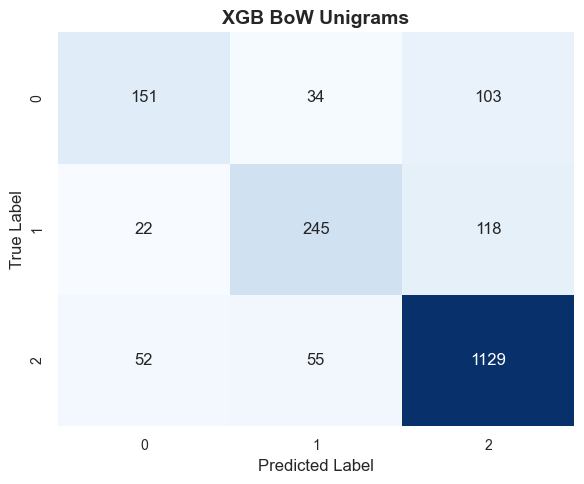

In [155]:
plot_confusion_matrix(y_val, y_val_pred_bow_unigrams, title=title, labels=[0, 1, 2], cmap="Blues")

### **6.1.2** Unigrams + Bigrams

In [156]:
model_xgb =  XGBClassifier(
    objective=objective, 
    num_class=num_class, 
    eval_metric=eval_metric, 
    use_label_encoder=use_label_encoder, 
    learning_rate=learning_rate, 
    max_depth=max_depth_xgboost, 
    n_estimators=n_estimators_xgboost, 
    subsample=subsample, 
    colsample_bytree=colsample_bytree
)

X_bow_bigrams, y_train_pred_bow_bigrams, y_val_pred_bow_bigrams, bow_bigrams = embedding_bow(x_train=x_train, y_train=y_train, x_val=x_val, max_df=max_df, min_df=min_df, model=model_xgb, ngram_range=(1,2))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:43:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [157]:
title = "XGB BoW Bigrams"

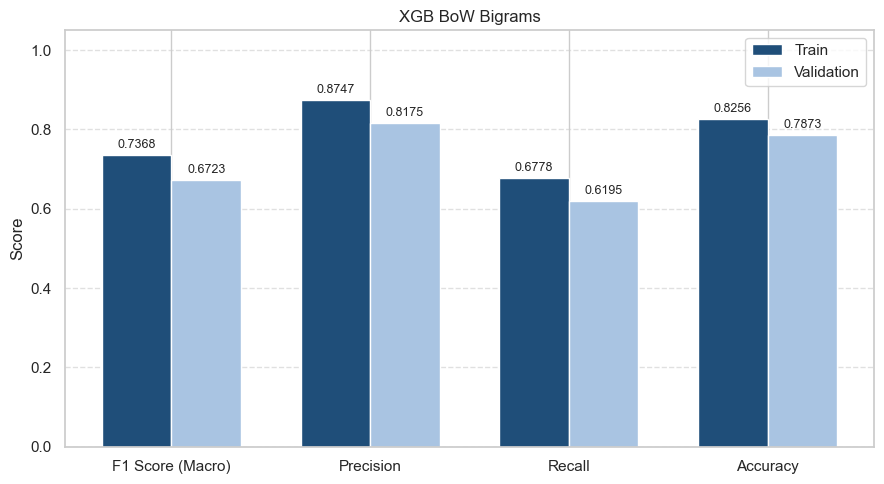

In [158]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_bow_bigrams, y_val, y_val_pred_bow_bigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_bow_bigrams, y_val, y_val_pred_bow_bigrams, title=title)

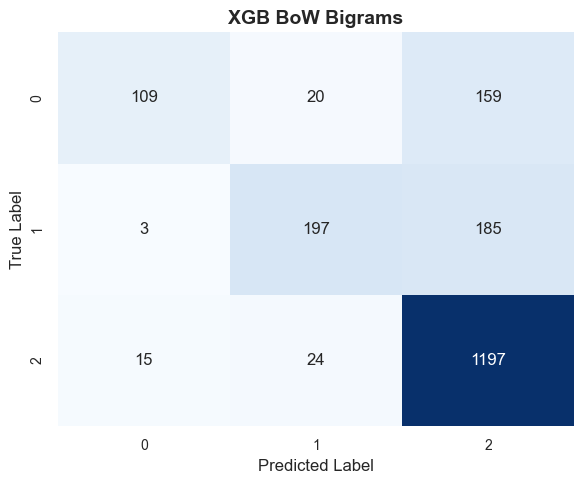

In [159]:
plot_confusion_matrix(y_val, y_val_pred_bow_bigrams, title=title, labels=[0, 1, 2], cmap="Blues")

## **6.2** TF-IDF

### **6.2.1** Unigrams

In [160]:
model_xgb =  XGBClassifier(
    objective=objective, 
    num_class=num_class, 
    eval_metric=eval_metric, 
    use_label_encoder=use_label_encoder, 
    learning_rate=learning_rate, 
    max_depth=max_depth_xgboost, 
    n_estimators=n_estimators_xgboost, 
    subsample=subsample, 
    colsample_bytree=colsample_bytree
)

X_tfidf_unigrams, y_train_pred_tfidf_unigrams, y_val_pred_tfidf_unigrams, tfidf_unigrams = embedding_tfidf(x_train=x_train, y_train=y_train, x_val=x_val, max_df=max_df, min_df=min_df, model=model_xgb,oversampling_function=oversample)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:43:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [161]:
title = "XGB TF-IDF Unigrams"

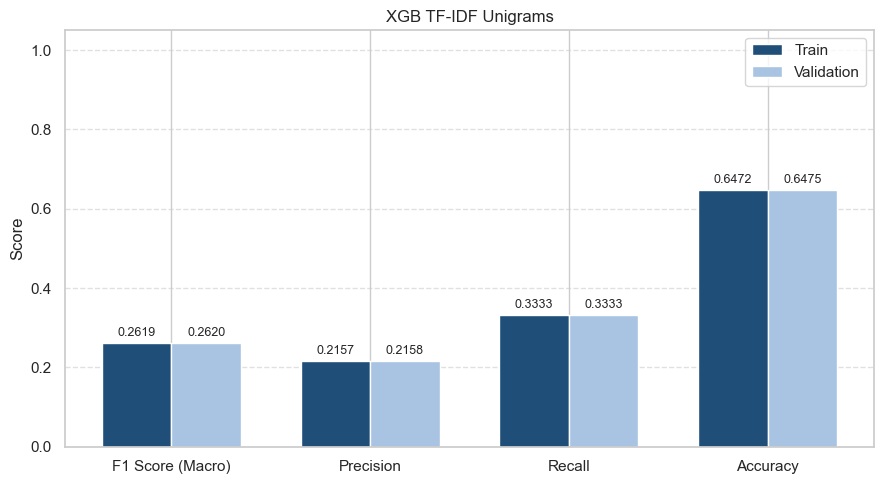

In [162]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_tfidf_unigrams, y_val, y_val_pred_tfidf_unigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_tfidf_unigrams, y_val, y_val_pred_tfidf_unigrams, title=title)

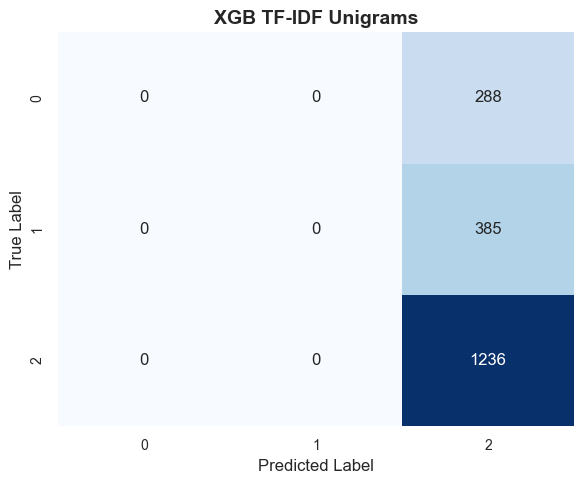

In [163]:
plot_confusion_matrix(y_val, y_val_pred_tfidf_unigrams, title=title, labels=[0, 1, 2], cmap="Blues")

### **6.2.2** Bigrams

In [164]:
model_xgb =  XGBClassifier(
    objective=objective, 
    num_class=num_class, 
    eval_metric=eval_metric, 
    use_label_encoder=use_label_encoder, 
    learning_rate=learning_rate, 
    max_depth=max_depth_xgboost, 
    n_estimators=n_estimators_xgboost, 
    subsample=subsample, 
    colsample_bytree=colsample_bytree
)

X_tfidf_bigrams, y_train_pred_tfidf_bigrams, y_val_pred_tfidf_bigrams, tfidf_bigrams = embedding_tfidf(x_train=x_train, y_train=y_train, x_val=x_val, max_df=max_df, min_df=min_df, model=model_xgb, ngram_range=(1,2))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:47:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [165]:
title = "XGB TF-IDF Bigrams"

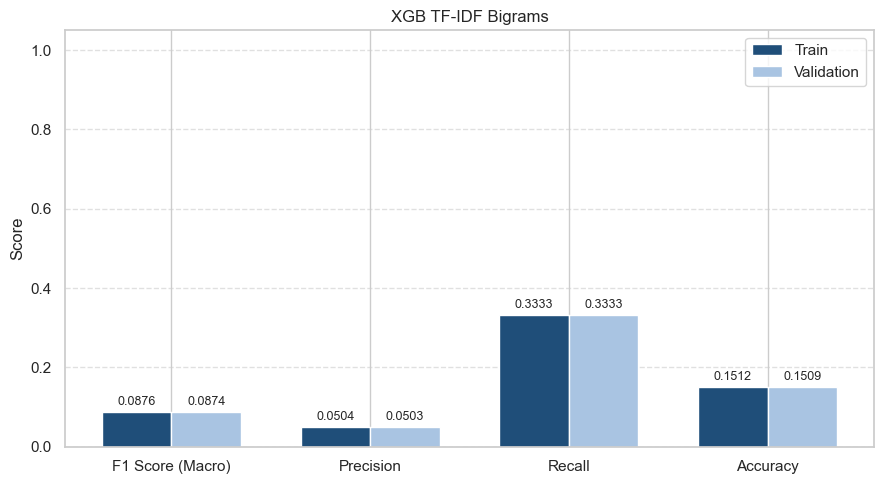

In [166]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_tfidf_bigrams, y_val, y_val_pred_tfidf_bigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_tfidf_bigrams, y_val, y_val_pred_tfidf_bigrams, title=title)

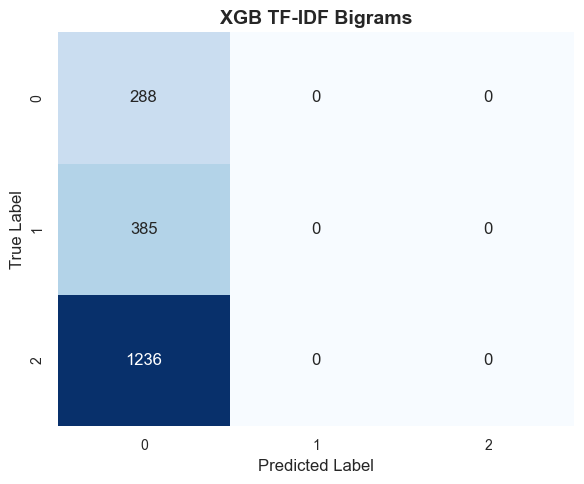

In [167]:
plot_confusion_matrix(y_val, y_val_pred_tfidf_bigrams, title=title, labels=[0, 1, 2], cmap="Blues")

## **6.3** Word2Vec

### **6.3.1** Minimum count = 1


In [168]:
model_xgb =  XGBClassifier(
    objective=objective, 
    num_class=num_class, 
    eval_metric=eval_metric, 
    use_label_encoder=use_label_encoder, 
    learning_rate=learning_rate, 
    max_depth=max_depth_xgboost, 
    n_estimators=n_estimators_xgboost, 
    subsample=subsample, 
    colsample_bytree=colsample_bytree
)

X_train_vec, y_train_pred_vec, y_val_pred_vec = embedding_word2vec(x_train=x_train, y_train=y_train, x_val=x_val, window=window, min_count=min_count, model=model_xgb)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:53:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [169]:
title = "XGB Word2Vec"

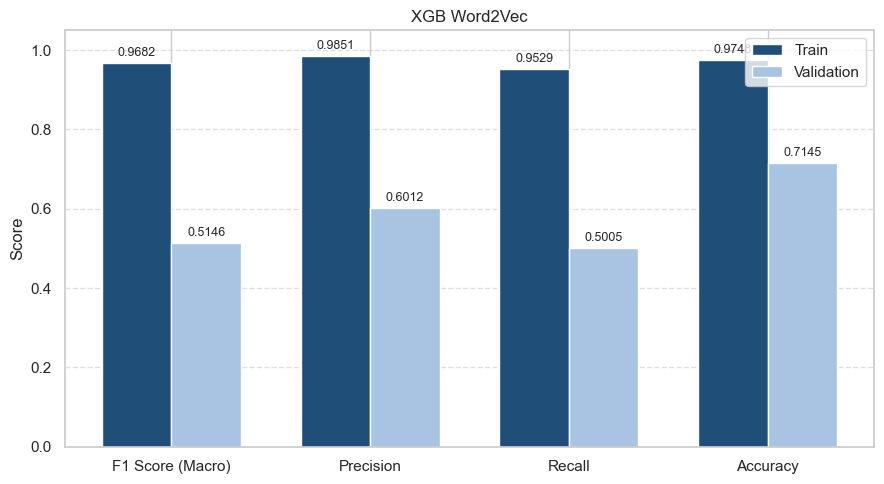

In [170]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_vec, y_val, y_val_pred_vec))

# Plot metrics
plot_metrics(y_train, y_train_pred_vec, y_val, y_val_pred_vec, title=title)

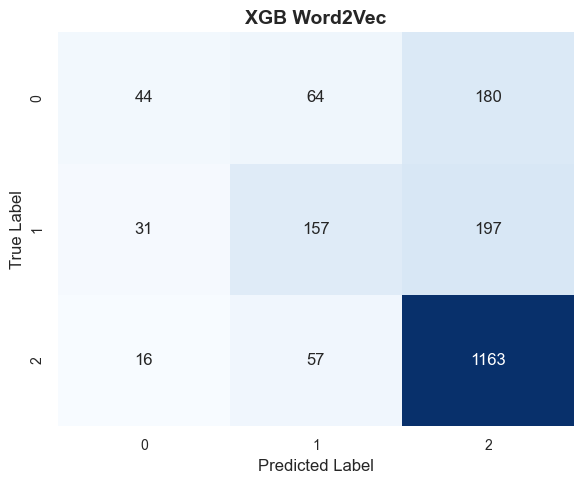

In [171]:
plot_confusion_matrix(y_val, y_val_pred_vec, title=title, labels=[0, 1, 2], cmap="Blues")

### **6.3.2** Minimum count based on percentile

In [172]:
model_xgb =  XGBClassifier(
    objective=objective, 
    num_class=num_class, 
    eval_metric=eval_metric, 
    use_label_encoder=use_label_encoder, 
    learning_rate=learning_rate, 
    max_depth=max_depth_xgboost, 
    n_estimators=n_estimators_xgboost, 
    subsample=subsample, 
    colsample_bytree=colsample_bytree
)

X_train_vec, y_train_pred_vec, y_val_pred_vec = embedding_word2vec(x_train=x_train, y_train=y_train, x_val=x_val, window=window, min_count=percentile_75, model=model_xgb)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:54:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [173]:
title = "XGB Word2Vec - Min count = 75th percentile"

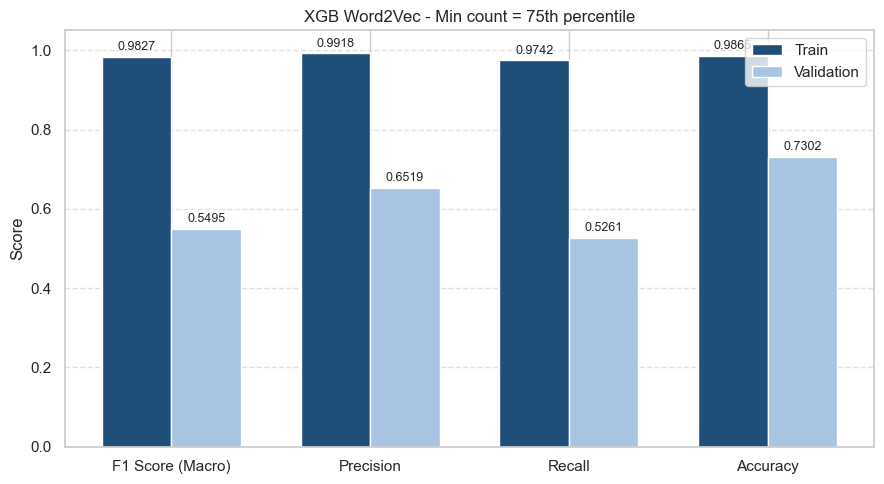

In [174]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_vec, y_val, y_val_pred_vec))

# Plot metrics
plot_metrics(y_train, y_train_pred_vec, y_val, y_val_pred_vec, title=title)

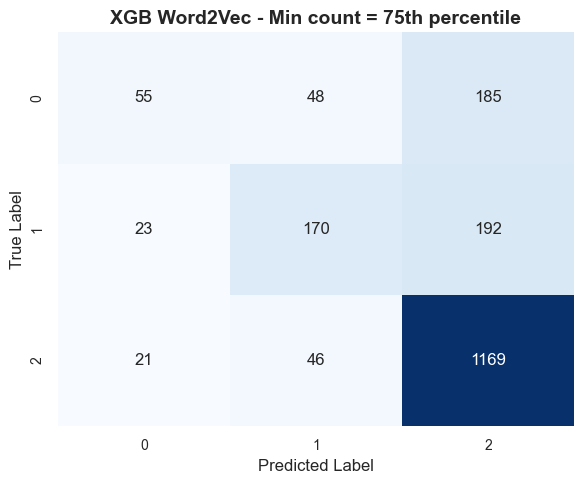

In [175]:
plot_confusion_matrix(y_val, y_val_pred_vec, title=title, labels=[0, 1, 2], cmap="Blues")

## **6.4** Glove

In [176]:
model_xgb =  XGBClassifier(
    objective=objective, 
    num_class=num_class, 
    eval_metric=eval_metric, 
    use_label_encoder=use_label_encoder, 
    learning_rate=learning_rate, 
    max_depth=max_depth_xgboost, 
    n_estimators=n_estimators_xgboost, 
    subsample=subsample, 
    colsample_bytree=colsample_bytree
)

X_train_glove_avg, y_train_pred_glove, y_val_pred_glove = embedding_glove(x_train=x_train, y_train=y_train, x_val=x_val, model_glove = glove_model, emb_size=emb_size, model=model_xgb)

100%|██████████| 1909/1909 [00:00<00:00, 25319.30it/s]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:54:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [177]:
title = "XGB Glove"

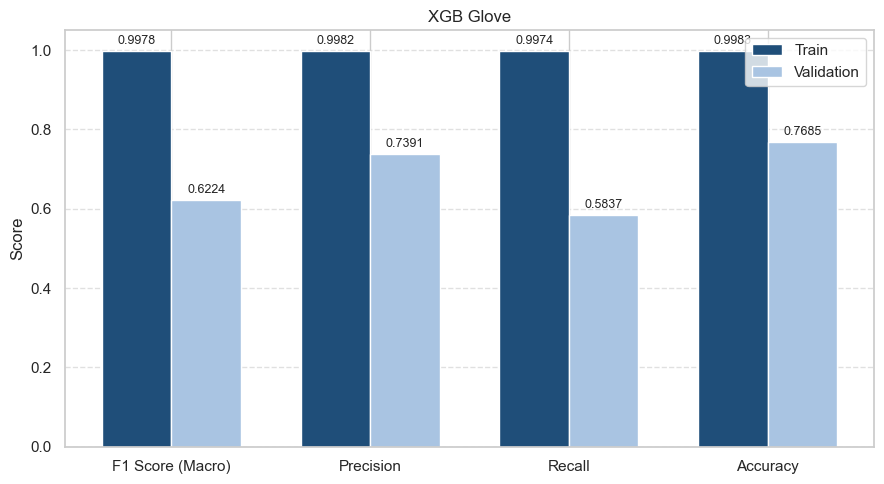

In [178]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_glove, y_val, y_val_pred_glove))

# Plot metrics
plot_metrics(y_train, y_train_pred_glove, y_val, y_val_pred_glove, title=title)

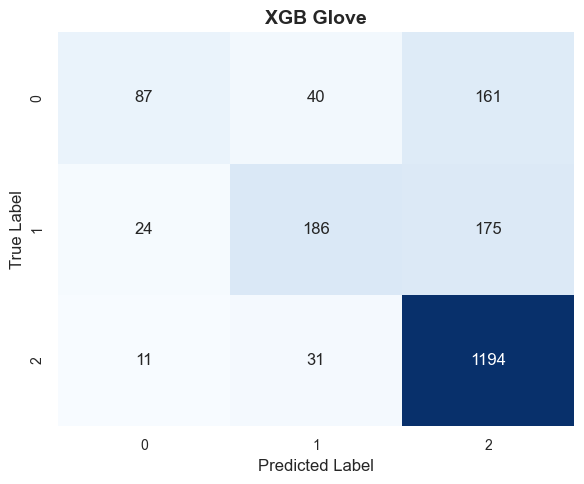

In [179]:
plot_confusion_matrix(y_val, y_val_pred_glove, title=title, labels=[0, 1, 2], cmap="Blues")

## **6.5** Text Embedding 3 Small - EXTRA

In [180]:
model_xgb =  XGBClassifier(
    objective=objective, 
    num_class=num_class, 
    eval_metric=eval_metric, 
    use_label_encoder=use_label_encoder, 
    learning_rate=learning_rate, 
    max_depth=max_depth_xgboost, 
    n_estimators=n_estimators_xgboost, 
    subsample=subsample, 
    colsample_bytree=colsample_bytree
)

X_train_te3s, y_train_pred_te3s,y_val_pred_te3s = embedding_te3s(train_texts=train_texts,
                                                                 train_labels=train_labels,
                                                                 val_texts = val_texts, 
                                                                 cache_file_train="X_train_te3s_embeddings.pkl", 
                                                                 cache_file_val="X_val_te3s_embeddings.pkl",
                                                                 client=client,
                                                                 model_te3s=model_te3s,
                                                                 batch_size=32,
                                                                 model=model_xgb)

Loading embeddings from X_train_te3s_embeddings.pkl...
Loading embeddings from X_val_te3s_embeddings.pkl...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:54:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [181]:
# Define the title for the metrics and plots
title = "XGB with Text Embedding 3 Small"

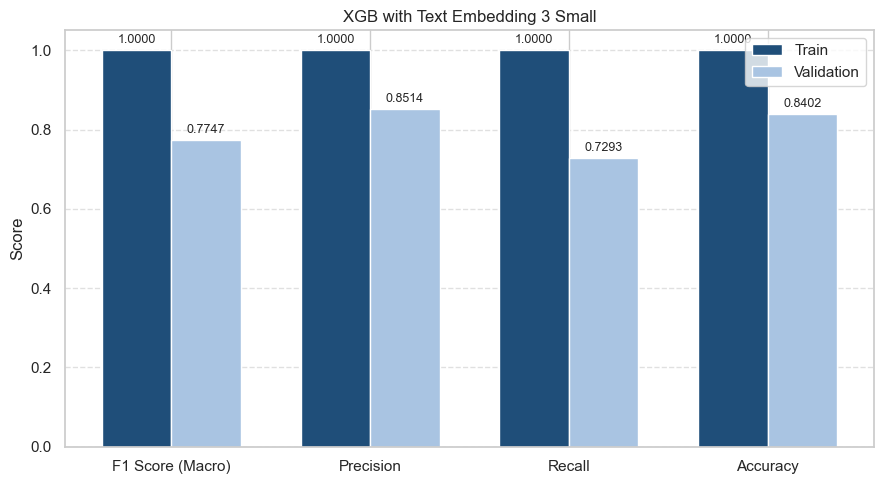

In [182]:
# Get metrics DataFrame
metrics_df.append(get_metrics_df(title, train_labels, y_train_pred_te3s, val_labels, y_val_pred_te3s))
metrics_df

# Plot metrics
plot_metrics(train_labels, y_train_pred_te3s, val_labels, y_val_pred_te3s, title=title)

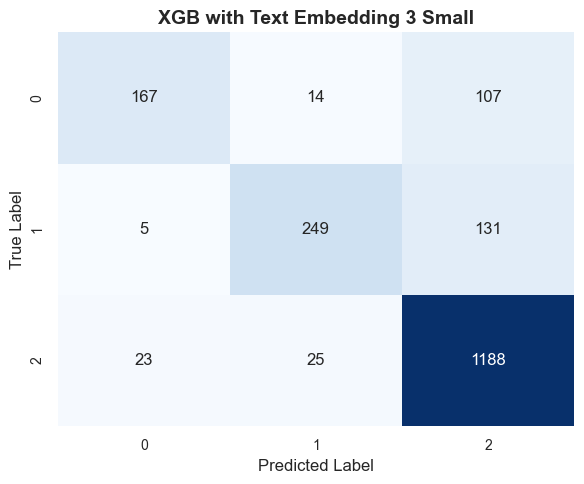

In [183]:
# Plot confusion matrix
plot_confusion_matrix(val_labels, y_val_pred_te3s, title=title, labels=[0, 1, 2], cmap="Blues")

## **6.6** Twitter Roberta Base - EXTRA

In [184]:
model_xgb =  XGBClassifier(
    objective=objective, 
    num_class=num_class, 
    eval_metric=eval_metric, 
    use_label_encoder=use_label_encoder, 
    learning_rate=learning_rate, 
    max_depth=max_depth_xgboost, 
    n_estimators=n_estimators_xgboost, 
    subsample=subsample, 
    colsample_bytree=colsample_bytree
)

X_train_roberta, y_train_pred_roberta,y_val_pred_roberta = embedding_roberta(train_texts=train_texts,
                                                                 train_labels=train_labels,
                                                                 val_texts = val_texts, 
                                                                 cache_file_train="X_train_roberta_embeddings.pkl", 
                                                                 cache_file_val="X_val_roberta_embeddings.pkl",
                                                                 tokenizer_roberta=tokenizer_roberta,
                                                                 model_roberta=model_roberta,
                                                                 batch_size=32,
                                                                 model=modelknn)

Loading RoBERTa embeddings from X_train_roberta_embeddings.pkl...
Loading RoBERTa embeddings from X_val_roberta_embeddings.pkl...


In [185]:
# Define the title for the metrics and plots
title = "XGB with RoBERTa"

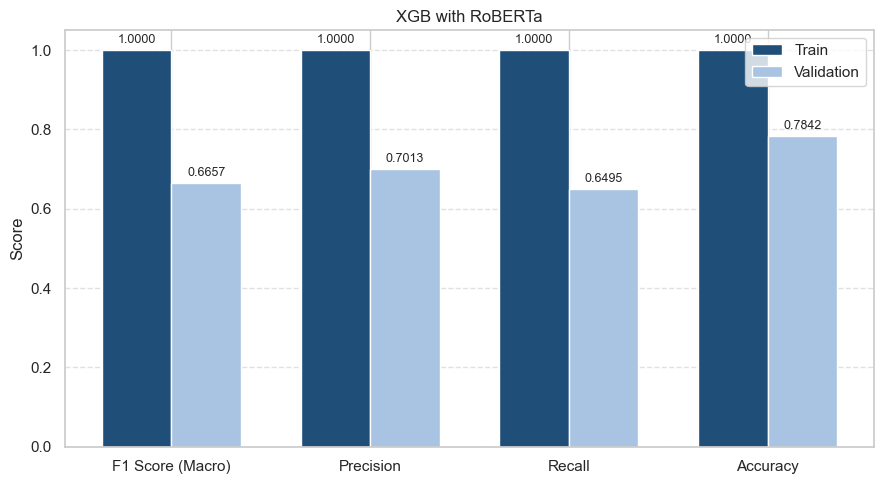

In [186]:
# Get metrics DataFrame
metrics_df.append(get_metrics_df(title, train_labels, y_train_pred_roberta, val_labels, y_val_pred_roberta))
metrics_df

# Plot metrics
plot_metrics(train_labels, y_train_pred_roberta, val_labels, y_val_pred_roberta, title=title)

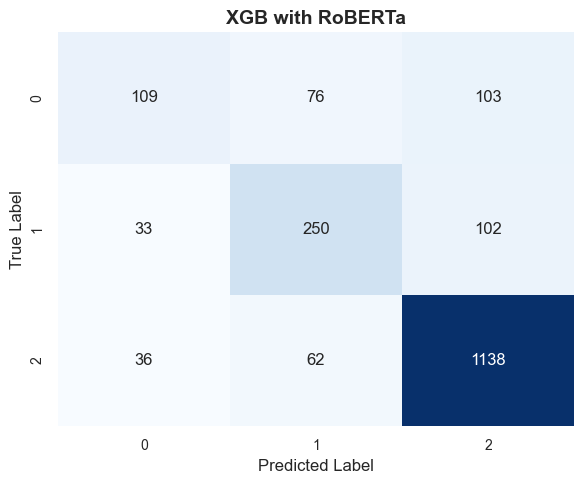

In [187]:
# Plot confusion matrix
plot_confusion_matrix(val_labels, y_val_pred_roberta, title=title, labels=[0, 1, 2], cmap="Blues")

<div class="alert alert-block alert-success">

# **7.** **LSTM**

<div>

BoW and TF-IDF are not suitable for LSTM due to lack of sequential structure

## **7.1** Word2Vec

In [188]:
model_lstm = Model(inputs=input_, outputs=output)
model_lstm.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

X_train_vec, y_train_pred_vec, y_val_pred_vec = embedding_word2vec_lstm(x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, window=window, n_classes=num_class, batch_size=batch_size, epochs=epochs, model_lstm=model_lstm, min_count=min_count)

Epoch 1/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - auc: 0.5812 - categorical_accuracy: 0.6548 - loss: 0.8850 - precision: 0.6732 - recall: 0.5369 - val_auc: 0.6803 - val_categorical_accuracy: 0.6946 - val_loss: 0.8116 - val_precision: 0.7222 - val_recall: 0.6333
Epoch 2/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - auc: 0.7029 - categorical_accuracy: 0.6858 - loss: 0.7926 - precision: 0.7276 - recall: 0.6157 - val_auc: 0.6938 - val_categorical_accuracy: 0.7019 - val_loss: 0.7985 - val_precision: 0.7265 - val_recall: 0.6344
Epoch 3/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - auc: 0.7161 - categorical_accuracy: 0.6905 - loss: 0.7810 - precision: 0.7303 - recall: 0.6203 - val_auc: 0.7019 - val_categorical_accuracy: 0.7061 - val_loss: 0.7940 - val_precision: 0.7367 - val_recall: 0.6171
Epoch 4/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - auc: 0.7283 - categorical_accuracy: 0.6928 - loss: 0.7693 - precision: 0.7371 - recall: 0.6199 - val_auc: 0.7082 - val_categorical_accuracy:

In [189]:
title = "LSTM Word2Vec"

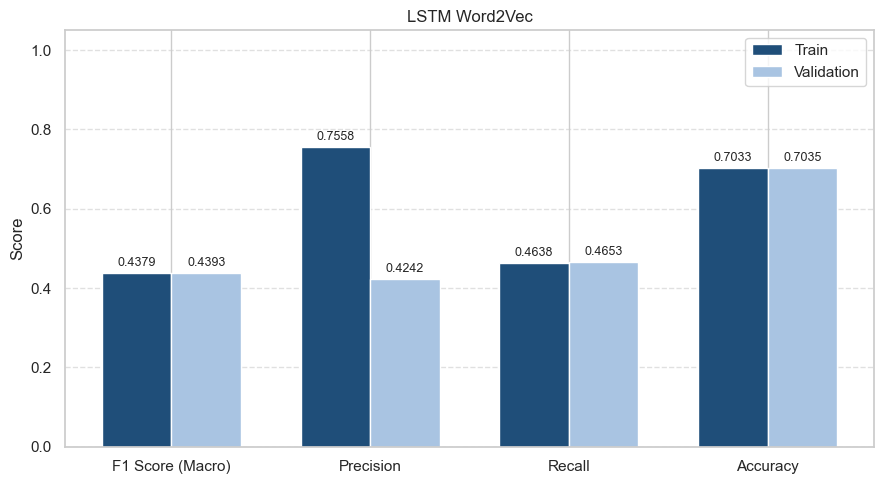

In [190]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_vec, y_val, y_val_pred_vec))

# Plot metrics
plot_metrics(y_train, y_train_pred_vec, y_val, y_val_pred_vec, title=title)

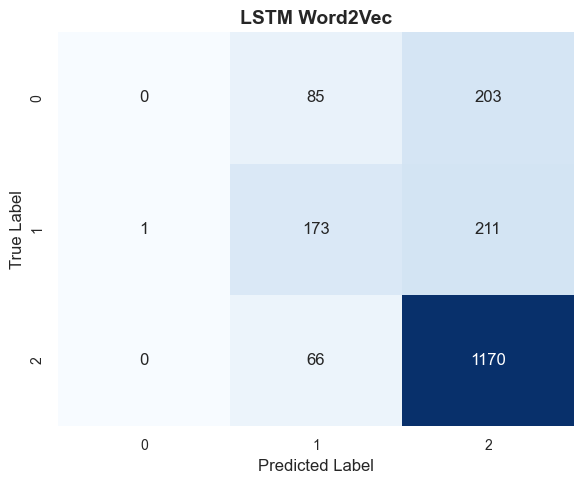

In [191]:
plot_confusion_matrix(y_val, y_val_pred_vec, title=title, labels=[0, 1, 2], cmap="Blues")

## **7.2** Glove

In [192]:
input_ = Input(shape=(26, 200))
x = Masking(mask_value=0.0)(input_)
x = Bidirectional(LSTM(units=units, return_sequences=False, dropout=dropout, recurrent_dropout=dropout))(x)
x = Dropout(dropout)(x)
output = Dense(num_class, activation='softmax')(x)

In [193]:
optimizer=Adam(learning_rate=learning_rate_lstm)

In [194]:
model_lstm = Model(inputs=input_, outputs=output)
model_lstm.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

X_train_glove, y_train_pred_glove, y_val_pred_glove = embedding_glove_lstm(x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, model_glove = glove_model, n_classes=num_class, batch_size=batch_size, epochs=epochs, emb_size=emb_size, model_lstm=model_lstm)

100%|██████████| 1909/1909 [00:00<00:00, 16274.11it/s]


Epoch 1/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - auc: 0.7270 - categorical_accuracy: 0.6549 - loss: 0.8162 - precision: 0.7405 - recall: 0.5895 - val_auc: 0.8479 - val_categorical_accuracy: 0.7517 - val_loss: 0.6265 - val_precision: 0.7887 - val_recall: 0.7077
Epoch 2/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - auc: 0.8472 - categorical_accuracy: 0.7503 - loss: 0.6231 - precision: 0.8020 - recall: 0.6940 - val_auc: 0.8724 - val_categorical_accuracy: 0.7779 - val_loss: 0.5745 - val_precision: 0.8144 - val_recall: 0.7266
Epoch 3/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - auc: 0.8787 - categorical_accuracy: 0.7744 - loss: 0.5645 - precision: 0.8210 - recall: 0.7229 - val_auc: 0.8813 - val_categorical_accuracy: 0.7899 - val_loss: 0.5540 - val_precision: 0.8166 - val_recall: 0.7438
Epoch 4/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - auc: 0.9008 - categorical_accuracy: 0.8036 - loss: 0.5079 - precision: 0.8381 - recall: 0.7632 - val_auc: 0.8905 - val_categorical_accuracy:

In [195]:
title = "LSTM Glove"

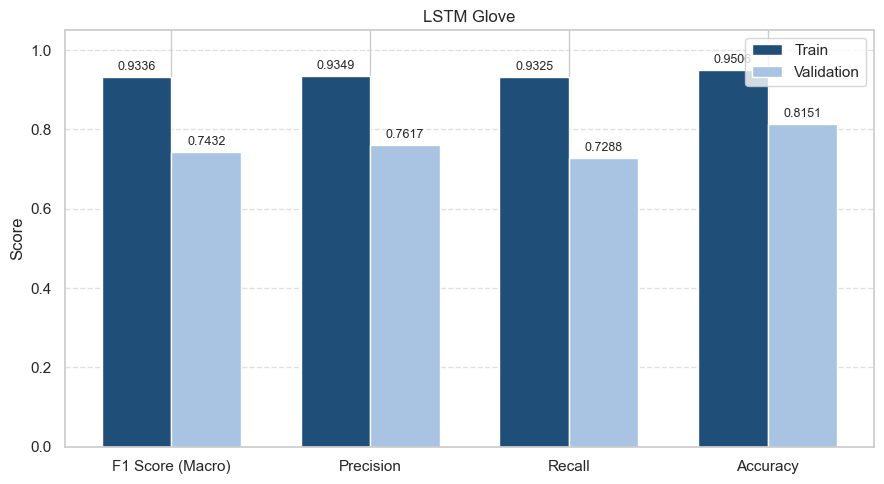

In [196]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_glove, y_val, y_val_pred_glove))

# Plot metrics
plot_metrics(y_train, y_train_pred_glove, y_val, y_val_pred_glove, title=title)

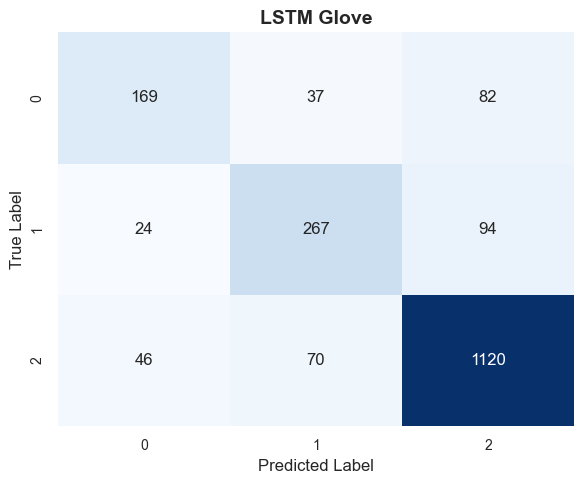

In [197]:
plot_confusion_matrix(y_val, y_val_pred_glove, title=title, labels=[0, 1, 2], cmap="Blues")

<div class="alert alert-block alert-success">

# **8.** **Comparison**

<div>

In [ ]:
metrics_df = pd.concat(metrics_df, ignore_index=True)

In [214]:
metrics_df.to_csv('metrics_df.csv', mode='a', header=True, index=41)

In [13]:
# Base DataFrame
metrics_df = pd.read_csv("metrics_df.csv")
metrics_df = metrics_df.loc[:, ~metrics_df.columns.str.contains('^Unnamed')]
metrics_df

,Model,Embedding,Train F1 (Macro),Val F1 (Macro),Train Precision,Val Precision,Train Recall,Val Recall,Train Accuracy,Val Accuracy
0,KNN,BoW Unigrams,0.9987,0.6786,0.9987,0.7388,0.9988,0.6541,0.9991,0.7873
1,KNN,BoW Bigrams,0.9986,0.5358,0.9983,0.5460,0.9989,0.6052,0.9990,0.5783
2,KNN,TF-IDF Unigrams,0.9987,0.6980,0.9983,0.7478,0.9992,0.6726,0.9991,0.7968
3,KNN,TF-IDF Bigrams,0.9987,0.6864,0.9985,0.7389,0.9990,0.6605,0.9991,0.7889
4,KNN,Word2Vec,0.9991,0.5272,0.9988,0.5824,0.9993,0.5121,0.9993,0.7087
5,KNN,Glove,0.9983,0.6187,0.9976,0.6600,0.9990,0.6041,0.9987,0.7606
6,KNN,Text Embedding 3 Small,1.0000,0.7478,1.0000,0.7530,1.0000,0.7435,1.0000,0.8119
7,KNN,RoBERTa,1.0000,0.6657,1.0000,0.7013,1.0000,0.6495,1.0000,0.7842
8,Naive Bayes,BoW Unigrams,0.8663,0.6975,0.8853,0.7606,0.8520,0.6655,0.8993,0.7957
9,Naive Bayes,BoW Bigrams,0.9782,0.7009,0.9760,0.7919,0.9807,0.6600,0.9827,0.8030


In [14]:
# Define metrics to plot
metric_keys = {
    "Macro F1": ("Train F1 (Macro)", "Val F1 (Macro)"),
    "Precision": ("Train Precision", "Val Precision"),
    "Recall": ("Train Recall", "Val Recall"),
    "Accuracy": ("Train Accuracy", "Val Accuracy"),
}

# Loop to generate plots
for metric_name, (train_col, val_col) in metric_keys.items():
    df_metric = metrics_df.melt(
        id_vars=["Model"],
        value_vars=[train_col, val_col],
        var_name="Set",
        value_name=metric_name
    )

    # Clean legend names
    df_metric["Set"] = df_metric["Set"].str.replace("Train.*", "Train", regex=True)
    df_metric["Set"] = df_metric["Set"].str.replace("Val.*", "Val", regex=True)

    # Order models by validation performance
    val_order = (
        df_metric[df_metric["Set"] == "Val"]
        .sort_values(metric_name, ascending=False)["Model"]
        .tolist()
    )

    # Create horizontal bar chart
    fig = px.bar(
        df_metric,
        y="Model",
        x=metric_name,
        color="Set",
        barmode="group",
        orientation="h",
        title=f"Train vs Validation {metric_name} per Model",
        template="plotly_white",
        category_orders={"Model": val_order},
        text=df_metric[metric_name].round(3)
    )

    # Move labels to the right of bars and enlarge
    fig.update_traces(
        textposition='outside',
        textfont_size=40,          
        cliponaxis=False
    )

    # Layout adjustments
    fig.update_layout(
        xaxis_title=metric_name,
        yaxis_title="Model",
        font=dict(size=18),
        width=1900,
        height=1300,
        legend=dict(font=dict(size=18)),
        margin=dict(l=250, r=100, t=80, b=80)
    )

    fig.show()

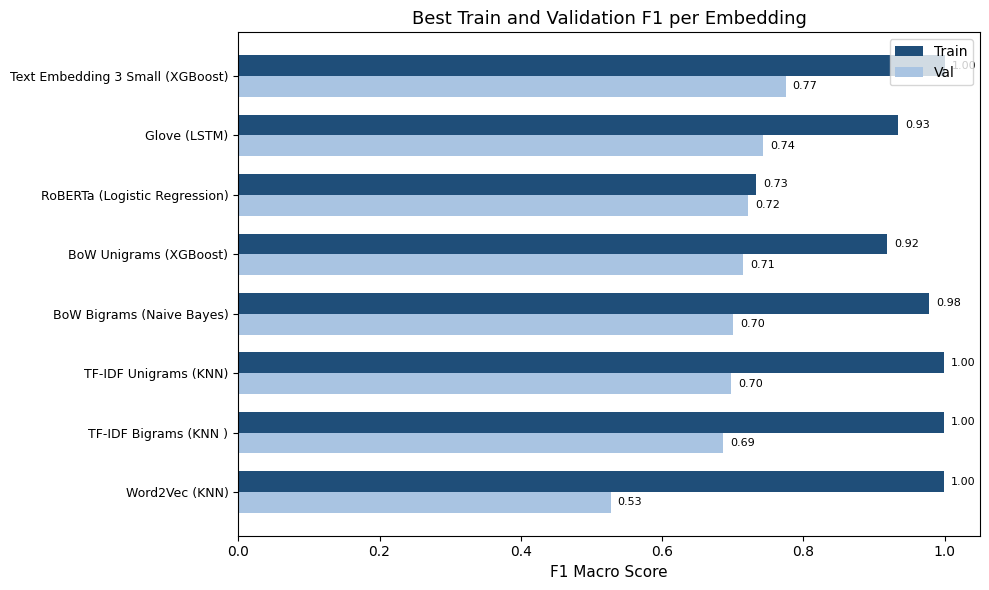

In [ ]:
plot_best_f1_by_embedding(metrics_df)

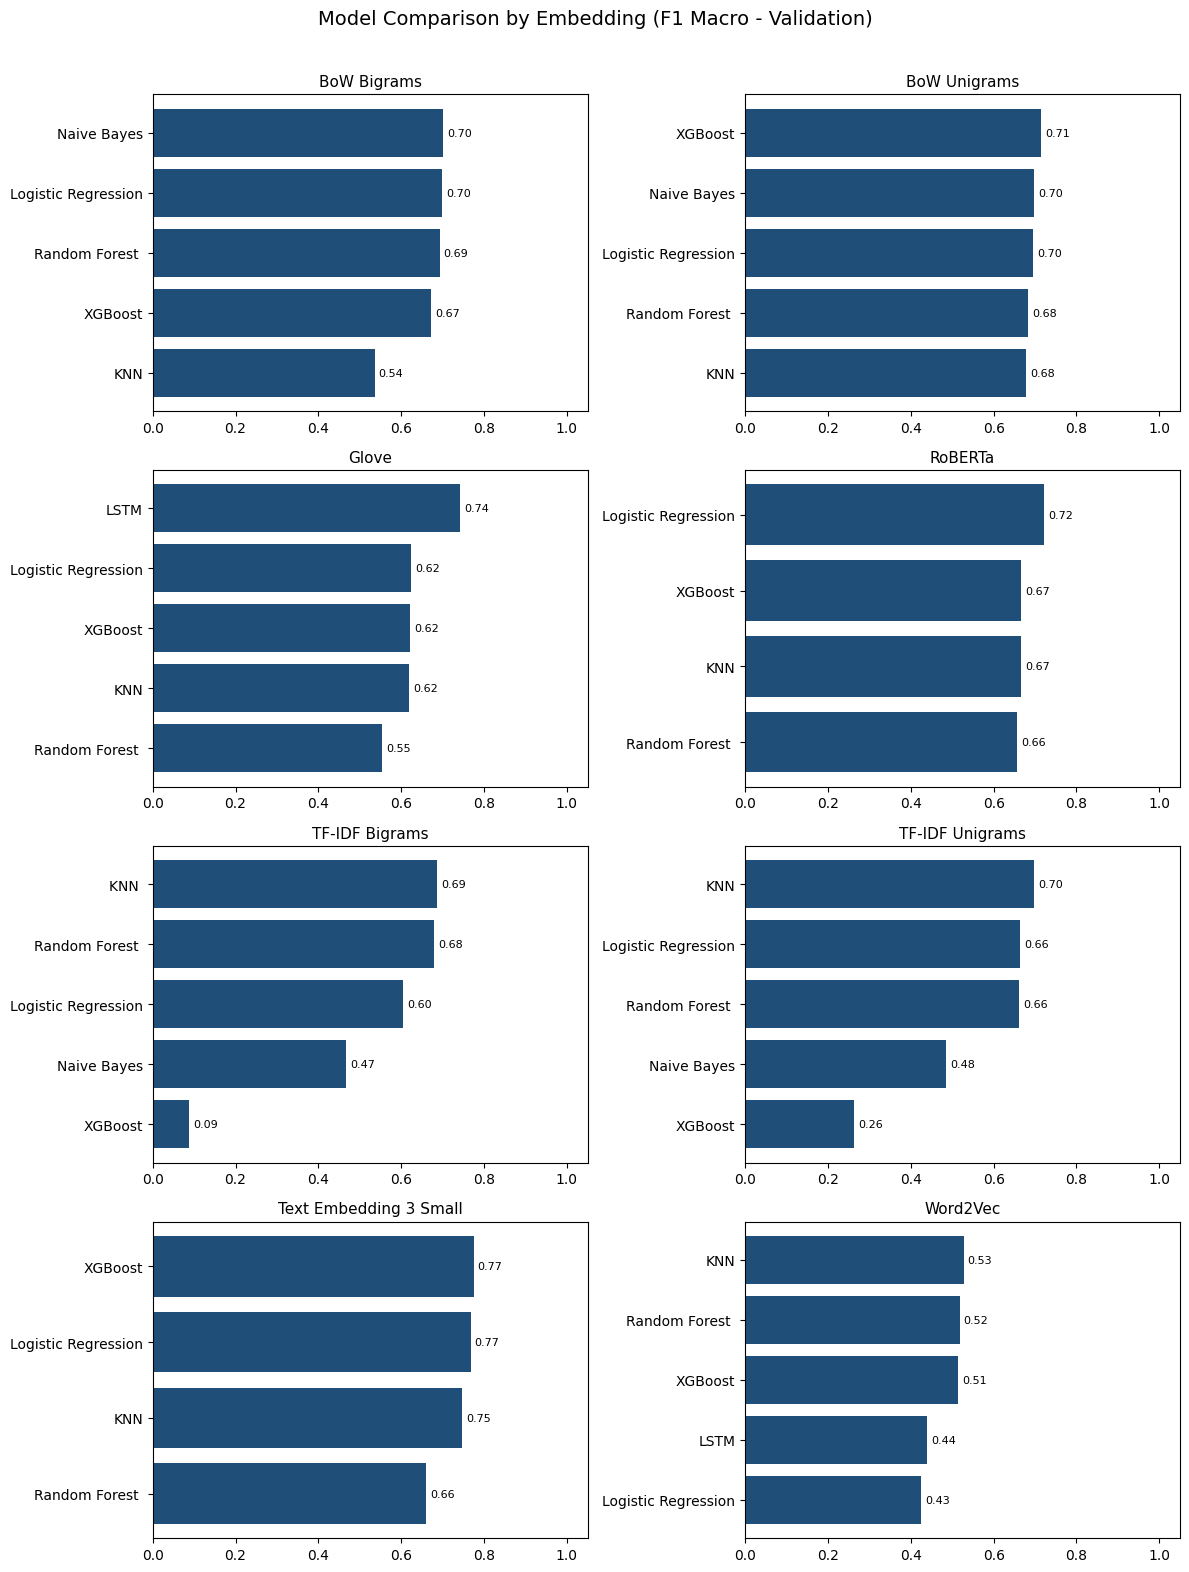

In [20]:
plot_model_comparison_all_embeddings(metrics_df)